In [27]:
#!/usr/bin/env python3

This script plots data over an spatial area. 

In [28]:
import os
import sys
from sys import exit as error
from time import process_time
from datetime import datetime
import warnings

import numpy
import matplotlib
import matplotlib.pyplot
import matplotlib.ticker
import matplotlib.axis
import mpl_toolkits.axes_grid1

import scipy.interpolate
import scipy.spatial
import shapely

AEMPYX_ROOT = os.environ["AEMPYX_ROOT"]
mypath = [AEMPYX_ROOT+"/aempy/modules/", AEMPYX_ROOT+"/aempy/scripts/"]
for pth in mypath:
    if pth not in sys.path:
        sys.path.insert(0,pth)

from version import versionstrg
import util
import aesys
import viz
import inverse

In [29]:
OutInfo = True
cm = 1/2.54
AEMPYX_DATA = os.environ["AEMPYX_DATA"]

version, _ = versionstrg()
script = "Tutorial1_VIZ_data_area.py"
# script = __file__  # this only works in python, not jupyter notebook
titstrng = util.print_title(version=version, fname=script, out=False)
print(titstrng+"\n\n")
Header = titstrng

AEMpyX Version 0.99.99
Date 05/20/2024, 16:44:55
Tutorial1_VIZ_data_area.py, modified 05/20/2024, 16:41:19
Tutorial1_VIZ_data_area.py




The following cell gives values to AEM-system related settings. 

Data transformation is activated by the variable _DataTrans_. Currently 
three possible options are allowed: _DataTrans = 0_: No transformation, 
i.e., the raw data are used. _DataTrans = 1_: The natural log of data 
is taken, only allowed for strictly positive values. _DataTrans = 2_: 
If data scale logarithmically, an _asinh_ transformation (introduced by
Scholl, 2000) is applied. It allows negatives, which may occur in TDEM, 
when IP effects are present.
       
A general additive/multiplicative error model is applied on the raw data
before transformation, and errors are also transformed.

In [30]:
# AEM_system = "genesis"
AEM_system = "aem05"
if "aem05" in AEM_system.lower():
    _, NN, _, _, Misc, = aesys.get_system_params(System=AEM_system)
    nL = NN[0]
    ParaTrans = 1
    DataTrans = 0
    DatErr_add =  50.
    DatErr_mult = 0.03
    data_active = numpy.ones(NN[2], dtype="int8")
    
    CompDict = Misc[3]
    CompLabl = list(CompDict.keys())
    print(CompLabl)

if "genes" in AEM_system.lower():
    _, NN, _, _, Misc, = aesys.get_system_params(System=AEM_system)
    nL = NN[0]
    ParaTrans = 1
    DataTrans = 2
    DatErr_add = 100.
    DatErr_mult = 0.01
    data_active = numpy.ones(NN[2], dtype="int8")
    data_active[0:11]=0  # only vertical component
    # data_active[10:11]=0  # Vertical + "good" hoizontals"
    CompDict =Misc[2]
    CompLabl = list(CompDict.keys())


AEM system is aem05
Forward model call: core1d.aemfwd1d_aem05(nlyr, m, alt)
Data:[17, 6, 8, 3]
['P1', 'Q1', 'P2', 'Q2', 'P3', 'Q3', 'P4', 'Q4', 'PLM', 'ALT']


In [31]:

InFileFmt = ".npz"

FileList = "search"  
SearchStrng = "*FL*.npz"# "search", "read"

AEMPYX_DATA = AEMPYX_ROOT+"/data/"  
InDatDir = AEMPYX_DATA+"/aem05_limerick/raw/"
PlotDir = AEMPYX_DATA+"/aem05_limerick/raw/plots/"
PlotStrng = " - data raw"
PlotName = "Limerick_shale_raw"

print("Data read from dir: %s " % InDatDir)
print("Plots written to dir: %s " % PlotDir)
print("Plot filname: %s " % PlotName)

# FileList = "read"
ListName = ""

Data read from dir: /home/vrath/AEMpyX_public//data//aem05_limerick/raw/ 
Plots written to dir: /home/vrath/AEMpyX_public//data//aem05_limerick/raw/plots/ 
Plot filname: Limerick_shale_raw 


In [32]:
if "set" in FileList.lower():
    dat_files = []

In [33]:
if "read" in FileList.lower():
    print("File names read from : "+ListName)
    how = ["read", ListName, InDatDir]
    dat_files = util.get_data_list(how=how,
                              out= True, sort=True)

    dat_files = numpy.loadtxt("A9-7.dat", dtype=str)

In [34]:
if "search" in FileList.lower():
    print("Searchstring is : "+SearchStrng)
    how = ["search", SearchStrng, InDatDir]
    dat_files = util.get_data_list(how=how, fullpath=True,
                              out= True, sort=True)

Searchstring is : *FL*.npz
Data files read from dir:  /home/vrath/AEMpyX_public//data//aem05_limerick/raw/
Search string: *FL*.npz 
76 data files found:
['/home/vrath/AEMpyX_public//data//aem05_limerick/raw/A5_rect_shale_FL5001-0.npz', '/home/vrath/AEMpyX_public//data//aem05_limerick/raw/A5_rect_shale_FL5002-0.npz', '/home/vrath/AEMpyX_public//data//aem05_limerick/raw/A5_rect_shale_FL5003-0.npz', '/home/vrath/AEMpyX_public//data//aem05_limerick/raw/A5_rect_shale_FL5004-0.npz', '/home/vrath/AEMpyX_public//data//aem05_limerick/raw/A5_rect_shale_FL5005-0.npz', '/home/vrath/AEMpyX_public//data//aem05_limerick/raw/A5_rect_shale_FL5006-0.npz', '/home/vrath/AEMpyX_public//data//aem05_limerick/raw/A5_rect_shale_FL5007-0.npz', '/home/vrath/AEMpyX_public//data//aem05_limerick/raw/A5_rect_shale_FL5008-0.npz', '/home/vrath/AEMpyX_public//data//aem05_limerick/raw/A5_rect_shale_FL5009-0.npz', '/home/vrath/AEMpyX_public//data//aem05_limerick/raw/A5_rect_shale_FL5010-0.npz', '/home/vrath/AEMpyX_public

In [35]:
ns = numpy.size(dat_files)
if ns ==0:
    error("No files set!. Exit.")

In [36]:
PlotFmt = [".pdf", ".png"] #".png", ".pdf",]
FilesOnly = True

In [37]:
PDFCatalog = True
PDFCName = PlotName+"_catalog.pdf"
if ".pdf" in PlotFmt:
    pass
else:
    error(" No pdfs generated. No catalog possible!")
    PDFCatalog = False

In [38]:
MergeData = True
DataMergeFile = InDatDir+PlotName+"_merged.npz"

In [39]:
ImageType = "image"
# ImageType = "contour"
# ImageType = "scatter"

In [40]:
XYUnits = "(km)"
XYFact = 0.001


Kernel functions for RBF:
    The radial basis function, based on the radius, r,
    given by the norm (default is Euclidean distance); the default is ‘multiquadric’:
        ‘linear’ : -r
        ‘thin_plate_spline’ : r**2 * log(r)
        ‘cubic’ : r**3
        ‘quintic’ : -r**5

If a callable, then it must take 2 arguments (self, r). The epsilon parameter
will be available as self.epsilon. Other keyword arguments passed
in will be available as well.


Methods for griddata:
        'nearest'       data point closest to the point of interpolation
        'linear'        tessellate the input point set to N-D simplices
                        and interpolate linearly on each simplex
        'cubic'         return the value determined from a piecewise cubic,
                        continuously differentiable (C1), and approximately
                        curvature-minimizing polynomial surface.


In [41]:
if ("image" in ImageType.lower()) or ("contour"in ImageType.lower()):
    step = 1

    InterpMethod = ["griddata","linear"]
    # InterpMethod = ["griddata", "cubic"]
    # InterpMethod = ["rbf", "linear", 0.0]
    # InterpMethod = ["rbf", "thin_plate_spline", 0.0]
    # InterpMethod = ["rbf", "cubic", 0.01]

    # InterpMethod = ["krig", "linear", 0.5, 340.]
    
    S = 500.
    numIndexes = [121, 141]
    smooth = 0.
    Levels = []
    MaskNeg = False
    MaskPoly = False
    MaskDist = True

    if MaskDist:
        DistMask = 100.*XYFact

    if MaskPoly:
        PolyDir = AEMPYX_DATA+"/Blocks/polygons/"
        PolyFiles = [PolyDir+"A5_2019_utm.npz"]
        Polygon= numpy.load(PolyFiles[0], allow_pickle=True)["Poly"][0]

In [42]:
if ("scatter" in ImageType.lower()):
    Decim=25
    step = min(1,abs(Decim))
    Markersize = 5
    MaskNeg = True
    Pixelsize = False
    if Pixelsize:
        step=10
        sfac = 10.

The following cell determines the settings for individual components. Each sublist associated to a componet contains the name, followed by a list of parameters determining the data limits, and a step determining the color bar, or the isolines. Further paramers, as e.g. the threshhold for the PLM, may be added.  

In [43]:
# CompList=[
#     ["Z3", []], #[0., 2000., 100.]],
#     ["Z6", []],#[0., 2000., 100.]],
#     ["Z9", []], #[0., 2000., 100.]],
#     ["H3", []], #[0., 2000., 100.]],
#     ["H6", []],#[0., 2000., 100.]],
#     ["H9", []], #[0., 2000., 100.]],
#     ["ALT", [80., 160., 20.], 240.]     # ALTthresh = 70.
          # ]

In [44]:
# CompList=[
    # ["P1", [0., 2000., 100.]],
    # ["Q1", [0., 2000., 100.]],
    # ["P2", [0., 2000., 100.]],
    # ["Q2", [0., 2000., 100.]],
    # ["P3", [0., 2000., 100.]],
    # ["Q3", [0., 2000., 100.]],
    # ["P4", [0., 2000., 100.]],
    # ["Q4", [0., 2000., 100.]],
    #["PLM", [], 0.2],      # PLMthresh = 0.25
    # ["ALT", [40., 120., 20.], 300.]     # ALTthresh = 70.
          # ]

In [45]:
CompList=[
    ["P1", [0., 3000., 200.]],
    ["Q1", [0., 3000., 200.]],
    ["P2", [0., 3000., 200.]],
    ["Q2", [0., 3000., 200.]],
    ["P3", [0., 3000., 200.]],
    ["Q3", [0., 3000., 200.]],
    ["P4", [0., 3000., 200.]],
    ["Q4", [0., 3000., 200.]],
    ["PLM", [], 3],      # PLMthresh = 0.25
    ["ALT", [40., 120., 20.], 125.]     # ALTthresh = 70.
]

Below, some graphic parameters are set, defining the style of the figure. A list of available styles can be printed with print(matplotlib.pyplot.style.available), and on the matplotlib web page at https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html.

In [46]:

matplotlib.pyplot.style.use("seaborn-v0_8-paper")
matplotlib.rcParams["figure.dpi"] = 400
matplotlib.rcParams["text.usetex"] = False
matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["axes.linewidth"] = 0.5
matplotlib.rcParams["savefig.facecolor"] = "none"
matplotlib.rcParams["savefig.bbox"]= "tight"

In [47]:
Fontsize = 7
Labelsize = Fontsize
Titlesize = 8
Fontsizes = [Fontsize, Labelsize, Titlesize]

In [48]:
Linewidths= [0.5]
FigWidth = 16.


Determine colormap. A comprehensive list of colormaps can be found at https://matplotlib.org/stable/gallery/color/colormap_reference.html


In [49]:
Cmap ="viridis"
Cmap = "hsv"
# Cmap ="magma"
Cmap = "jet_r"
# Cmap = "seismic"
# Cmap = "Spectral"
cmp = matplotlib.colormaps[Cmap]

xformatter = matplotlib.ticker.FormatStrFormatter("%.2f")
yformatter = matplotlib.ticker.FormatStrFormatter("%.2f")

In [50]:
if FilesOnly:
    matplotlib.use("cairo")

In [51]:
if not os.path.isdir(PlotDir):
    print("File: %s does not exist, but will be created" % PlotDir)
    os.mkdir(PlotDir)

In [52]:
if MergeData:
    Data = util.merge_data_sets(infile_list=dat_files,
                                outfile_name=DataMergeFile,
                                aem_system="aem05", out= True)
    dat_files = [DataMergeFile]


AEM system is aem05
Forward model call: core1d.aemfwd1d_aem05(nlyr, m, alt)
Data:[17, 6, 8, 3]

Data read from: /home/vrath/AEMpyX_public//data//aem05_limerick/raw/A5_rect_shale_FL5001-0.npz
['Data', 'Header', 'System']

Data read from: /home/vrath/AEMpyX_public//data//aem05_limerick/raw/A5_rect_shale_FL5002-0.npz
['Data', 'Header', 'System']

Data read from: /home/vrath/AEMpyX_public//data//aem05_limerick/raw/A5_rect_shale_FL5003-0.npz
['Data', 'Header', 'System']

Data read from: /home/vrath/AEMpyX_public//data//aem05_limerick/raw/A5_rect_shale_FL5004-0.npz
['Data', 'Header', 'System']

Data read from: /home/vrath/AEMpyX_public//data//aem05_limerick/raw/A5_rect_shale_FL5005-0.npz
['Data', 'Header', 'System']

Data read from: /home/vrath/AEMpyX_public//data//aem05_limerick/raw/A5_rect_shale_FL5006-0.npz
['Data', 'Header', 'System']

Data read from: /home/vrath/AEMpyX_public//data//aem05_limerick/raw/A5_rect_shale_FL5007-0.npz
['Data', 'Header', 'System']

Data read from: /home/vrath/


Data read from: /home/vrath/AEMpyX_public//data//aem05_limerick/raw/Limerick_shale_raw_merged.npz
['Data', 'Header', 'System']
Interpolation mesh, dx = 100.0 m, dy =93.0 m
Plotting component P1 - 912 Hz: 0/griddata/linear
Data, read   min=-1362.0   max=3976.0
Data, interpolated   min=-1102.5719731158777   max=3955.2259510089884
Plot written to /home/vrath/AEMpyX_public//data//aem05_limerick/raw/plots/Limerick_shale_raw_aem05_image_P1_griddata_linear.pdf


/tmp/ipykernel_17147/2744184302.py:229: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = matplotlib.pyplot.colorbar(im, cax=cax, extend="both")


Plot written to /home/vrath/AEMpyX_public//data//aem05_limerick/raw/plots/Limerick_shale_raw_aem05_image_P1_griddata_linear.png


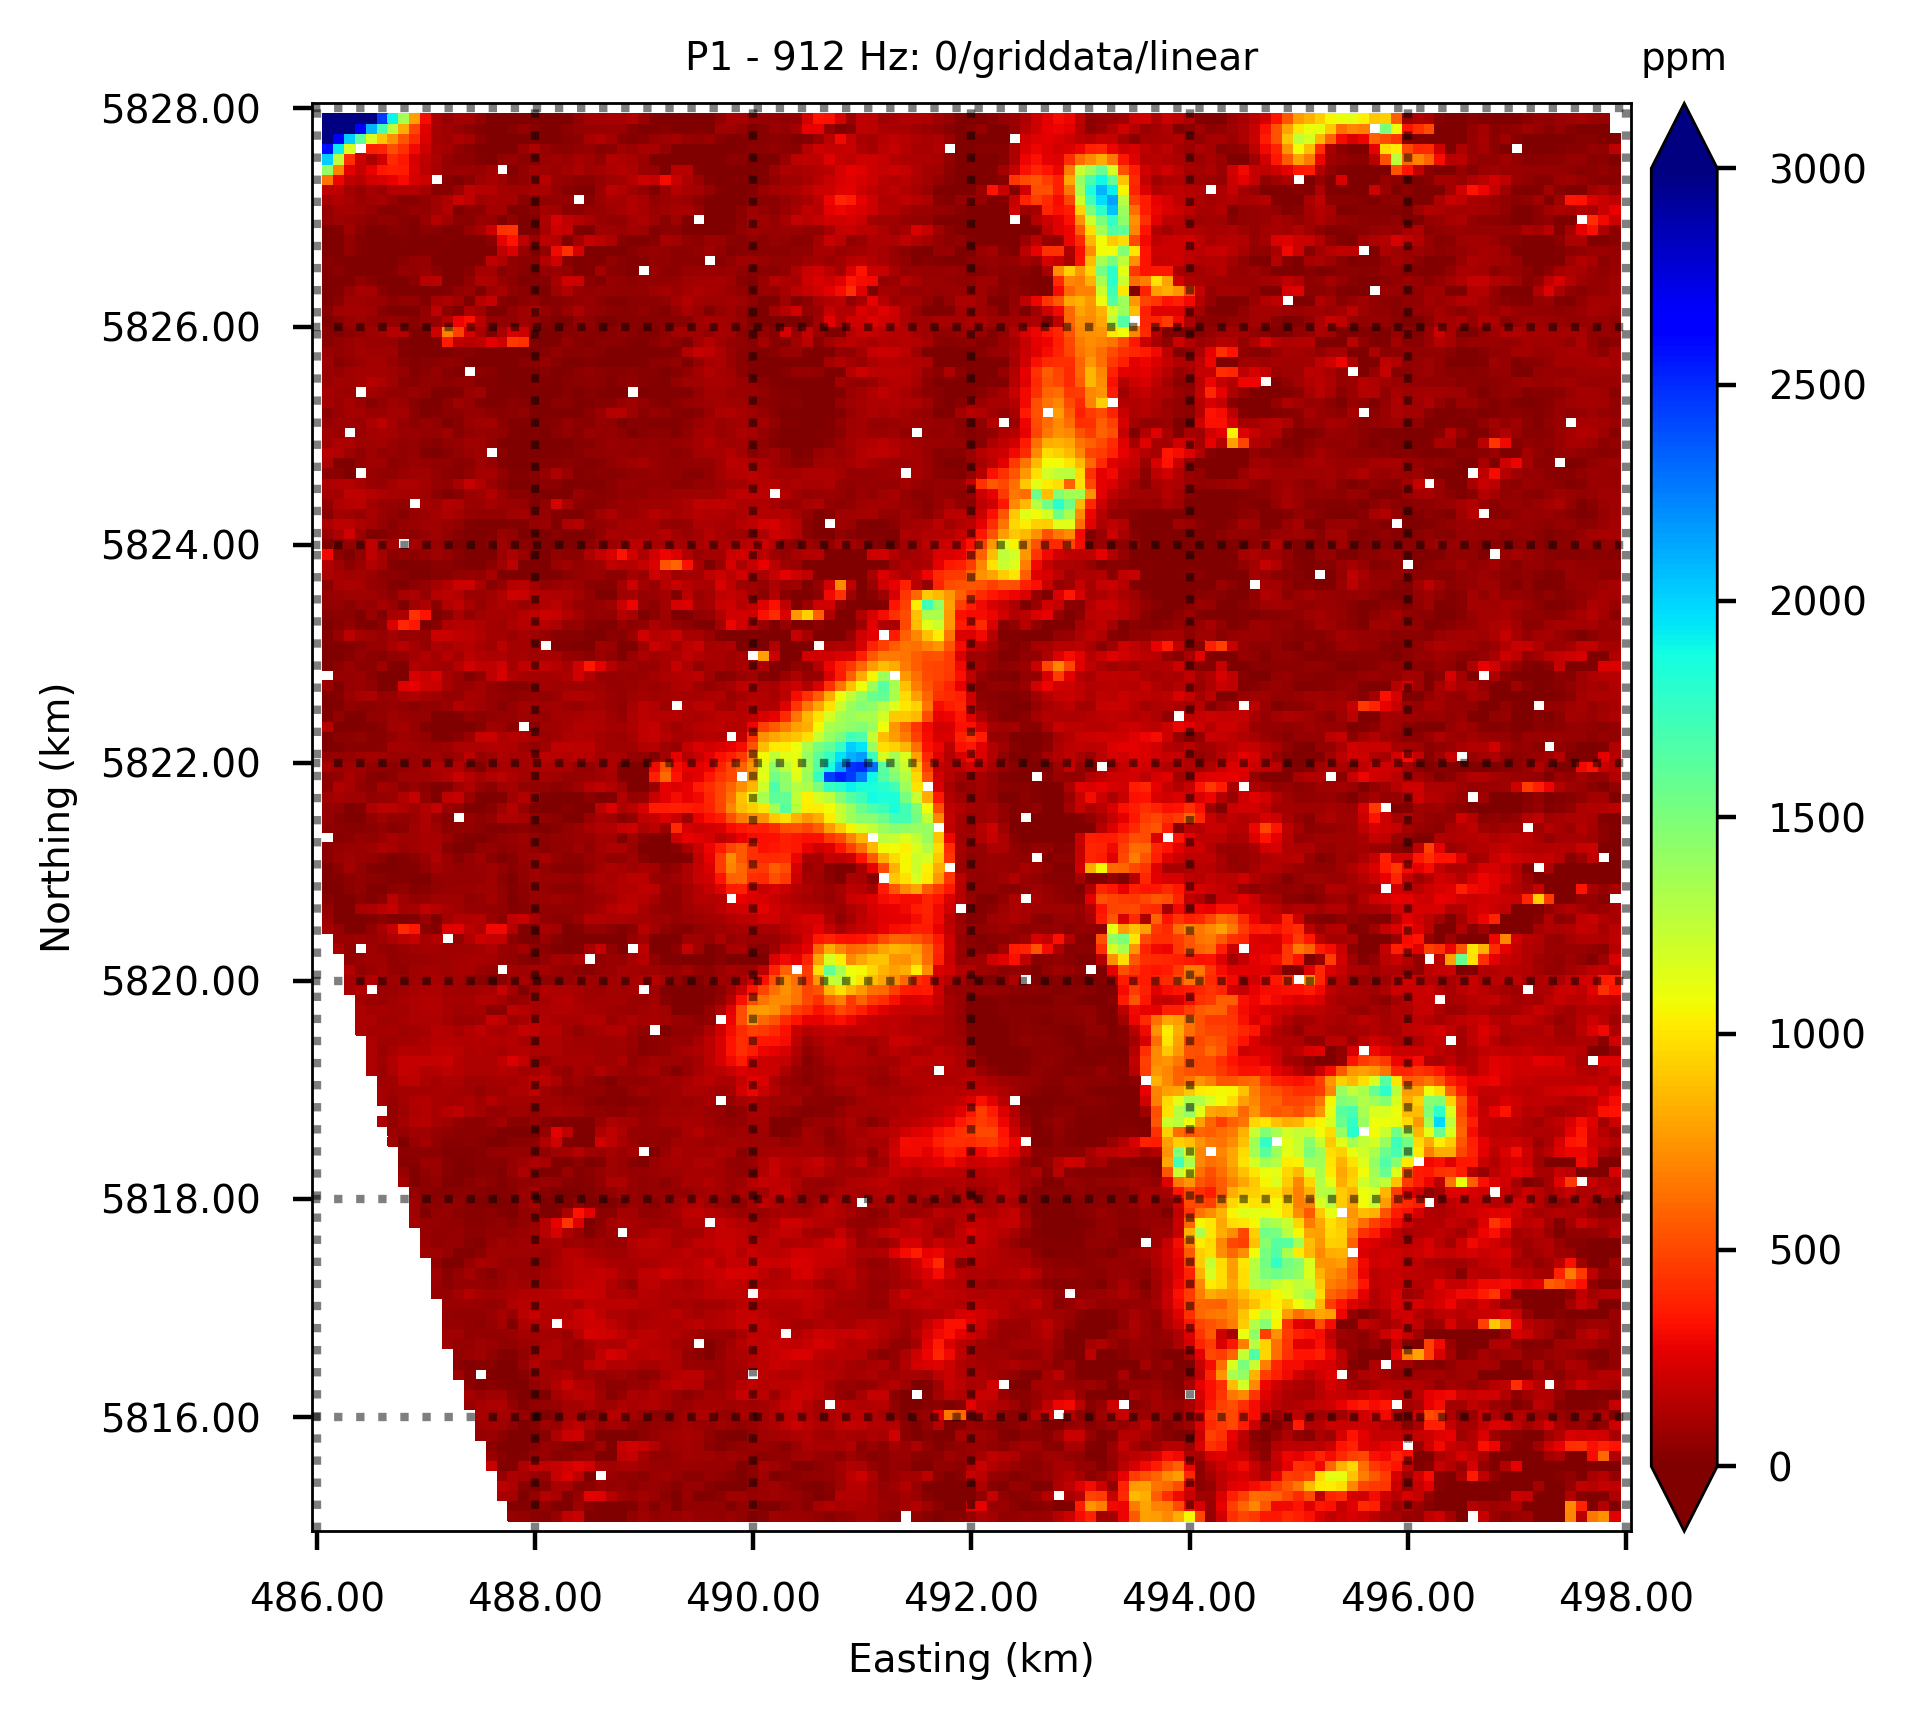

Plotting component Q1 - 912 Hz: 0/griddata/linear
Data, read   min=-1466.0   max=2428.0
Data, interpolated   min=-860.3502031441893   max=1936.3571140510649
Plot written to /home/vrath/AEMpyX_public//data//aem05_limerick/raw/plots/Limerick_shale_raw_aem05_image_Q1_griddata_linear.pdf
Plot written to /home/vrath/AEMpyX_public//data//aem05_limerick/raw/plots/Limerick_shale_raw_aem05_image_Q1_griddata_linear.png


<Figure size 2560x1760 with 0 Axes>

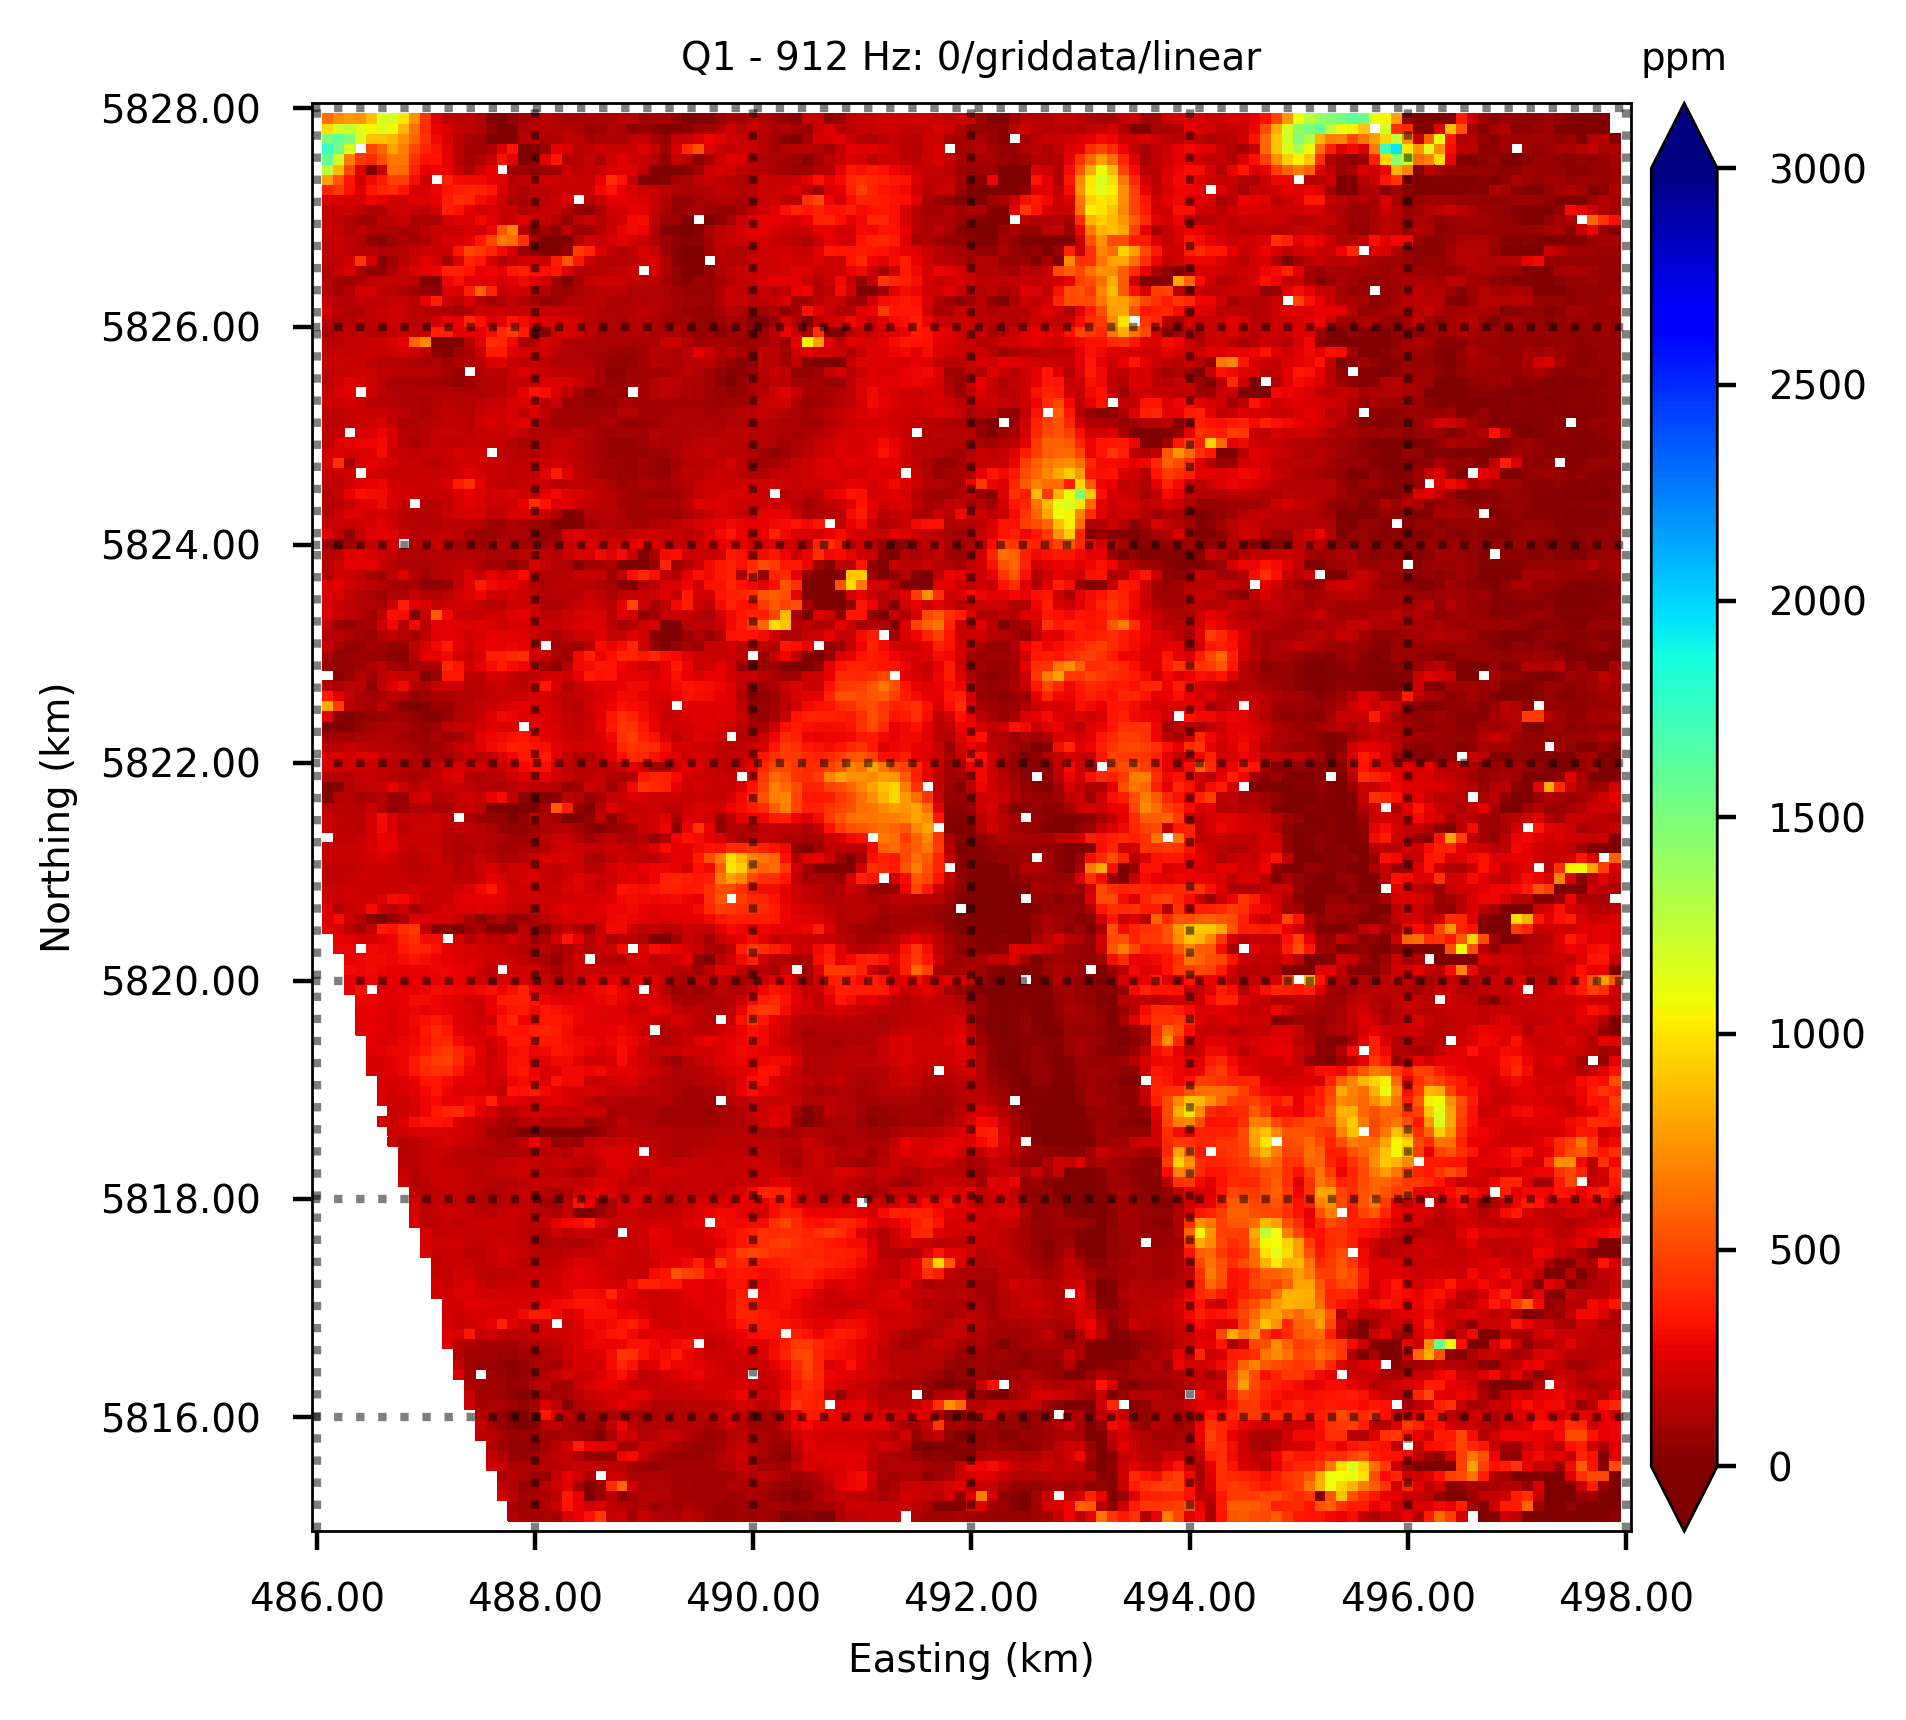

Plotting component P2 - 3005 Hz: 0/griddata/linear
Data, read   min=-564.0   max=4131.0
Data, interpolated   min=-357.1468685414998   max=4062.5239888163846
Plot written to /home/vrath/AEMpyX_public//data//aem05_limerick/raw/plots/Limerick_shale_raw_aem05_image_P2_griddata_linear.pdf
Plot written to /home/vrath/AEMpyX_public//data//aem05_limerick/raw/plots/Limerick_shale_raw_aem05_image_P2_griddata_linear.png


<Figure size 2560x1760 with 0 Axes>

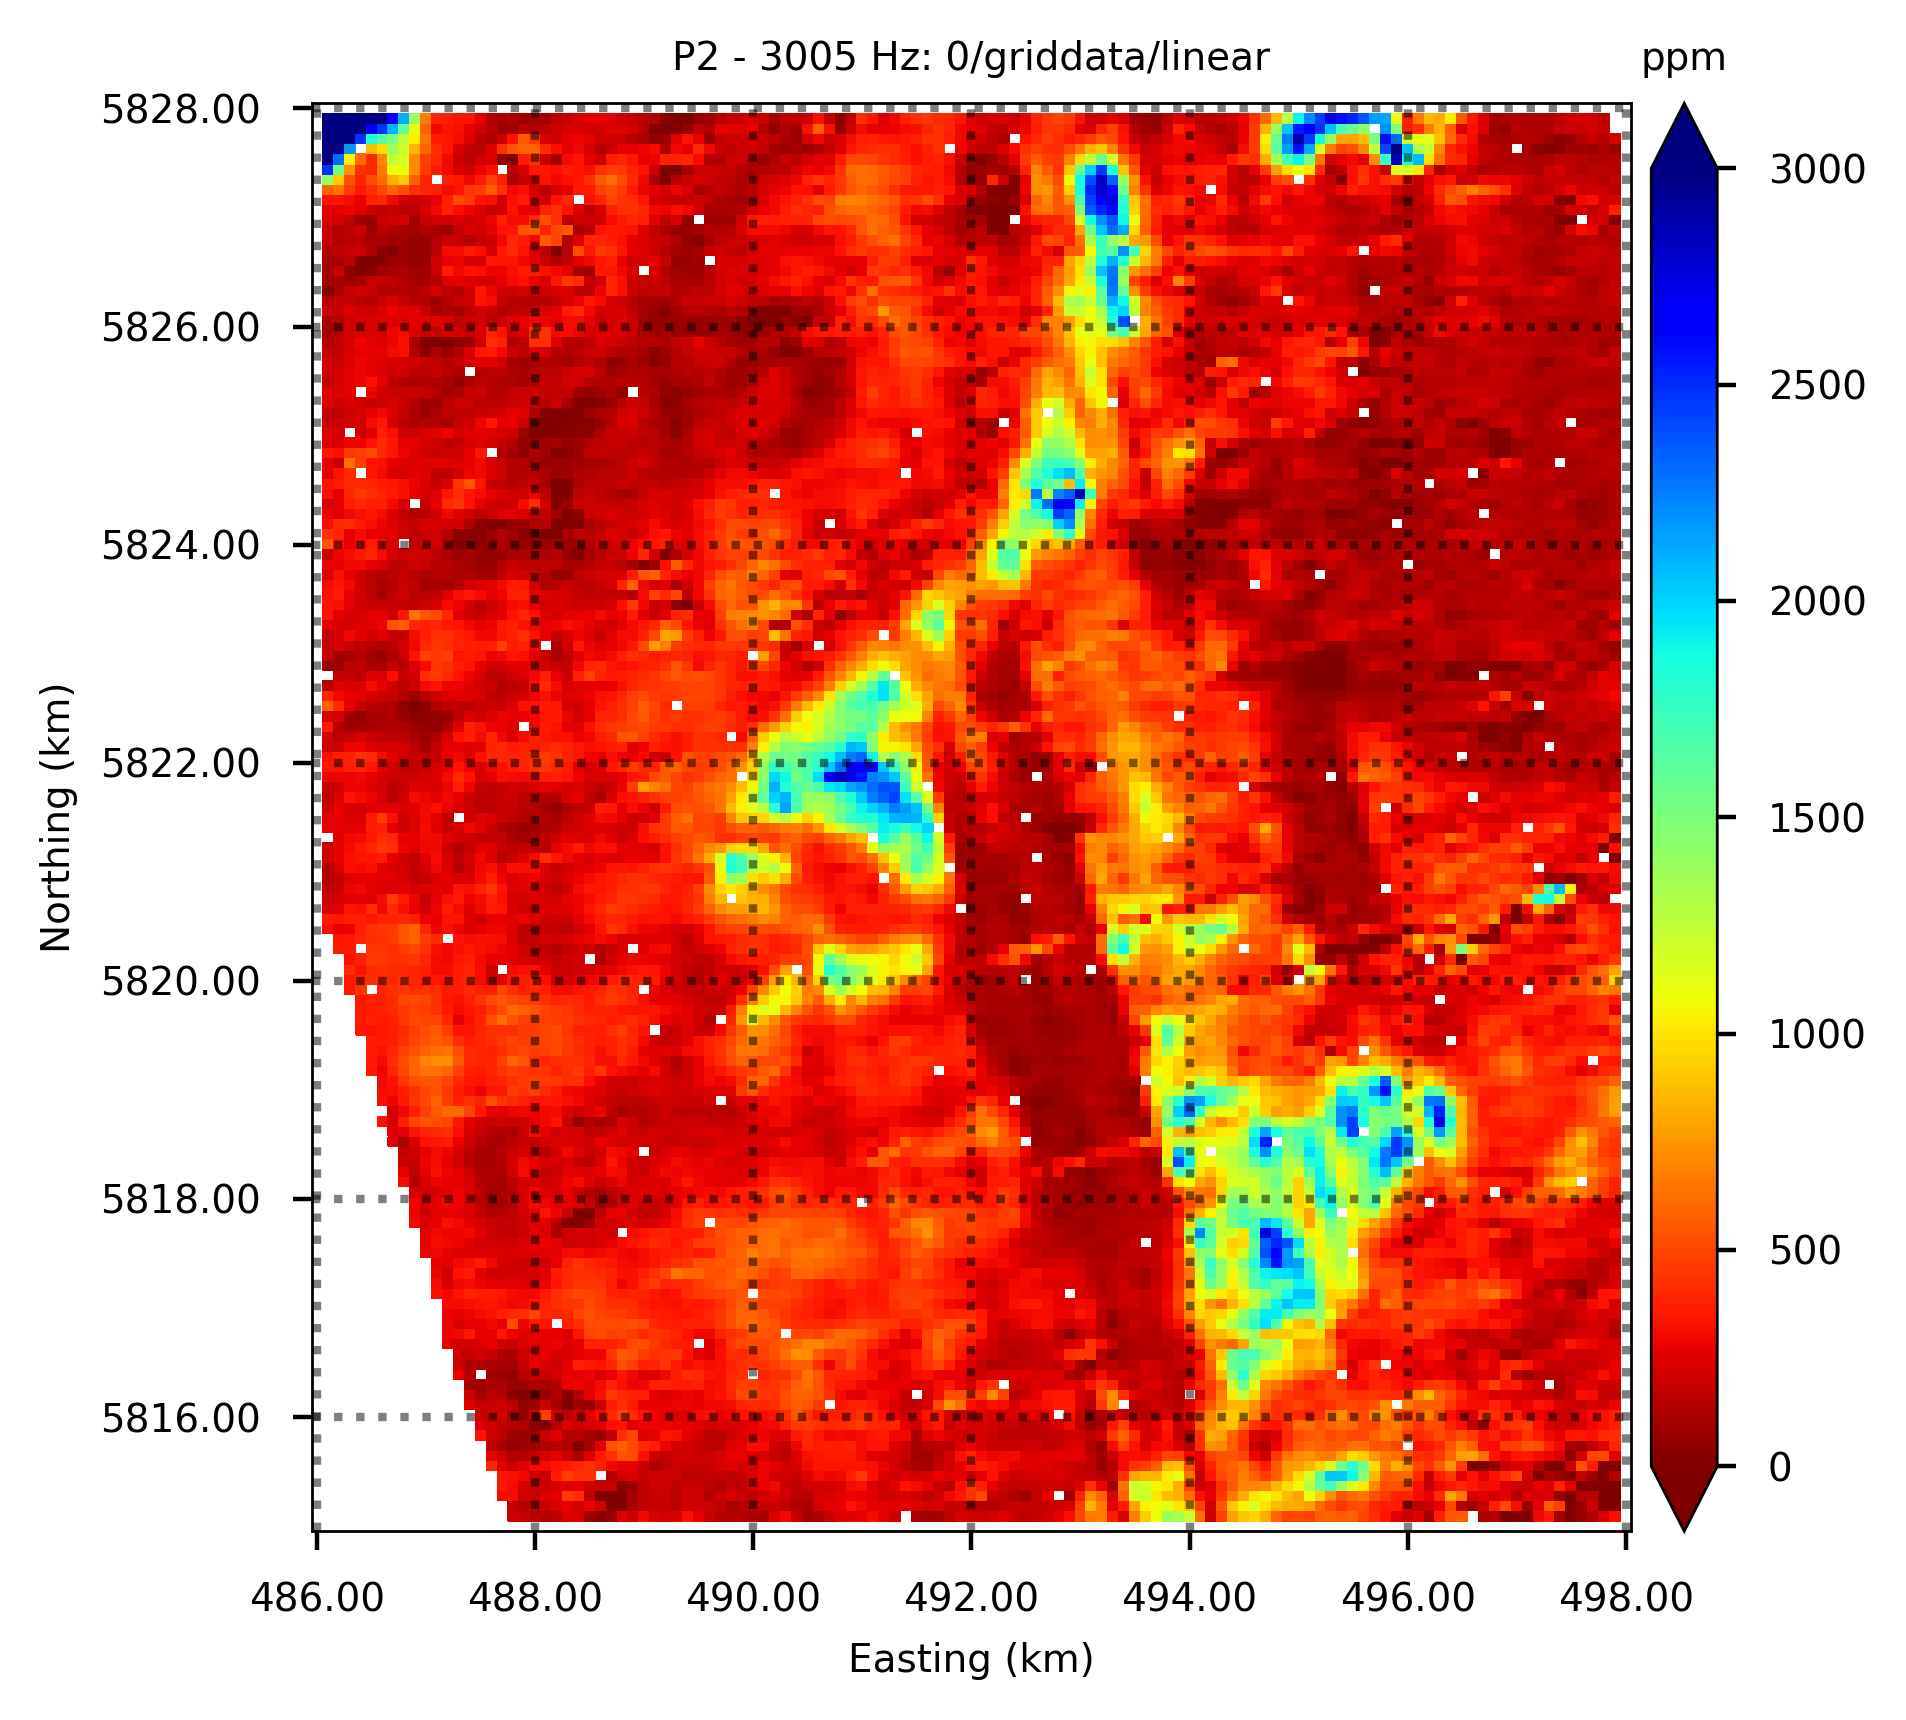

Plotting component Q2 - 3005 Hz: 0/griddata/linear
Data, read   min=-1527.0   max=2160.0
Data, interpolated   min=-904.5942360991164   max=1942.417332853796
Plot written to /home/vrath/AEMpyX_public//data//aem05_limerick/raw/plots/Limerick_shale_raw_aem05_image_Q2_griddata_linear.pdf
Plot written to /home/vrath/AEMpyX_public//data//aem05_limerick/raw/plots/Limerick_shale_raw_aem05_image_Q2_griddata_linear.png


<Figure size 2560x1760 with 0 Axes>

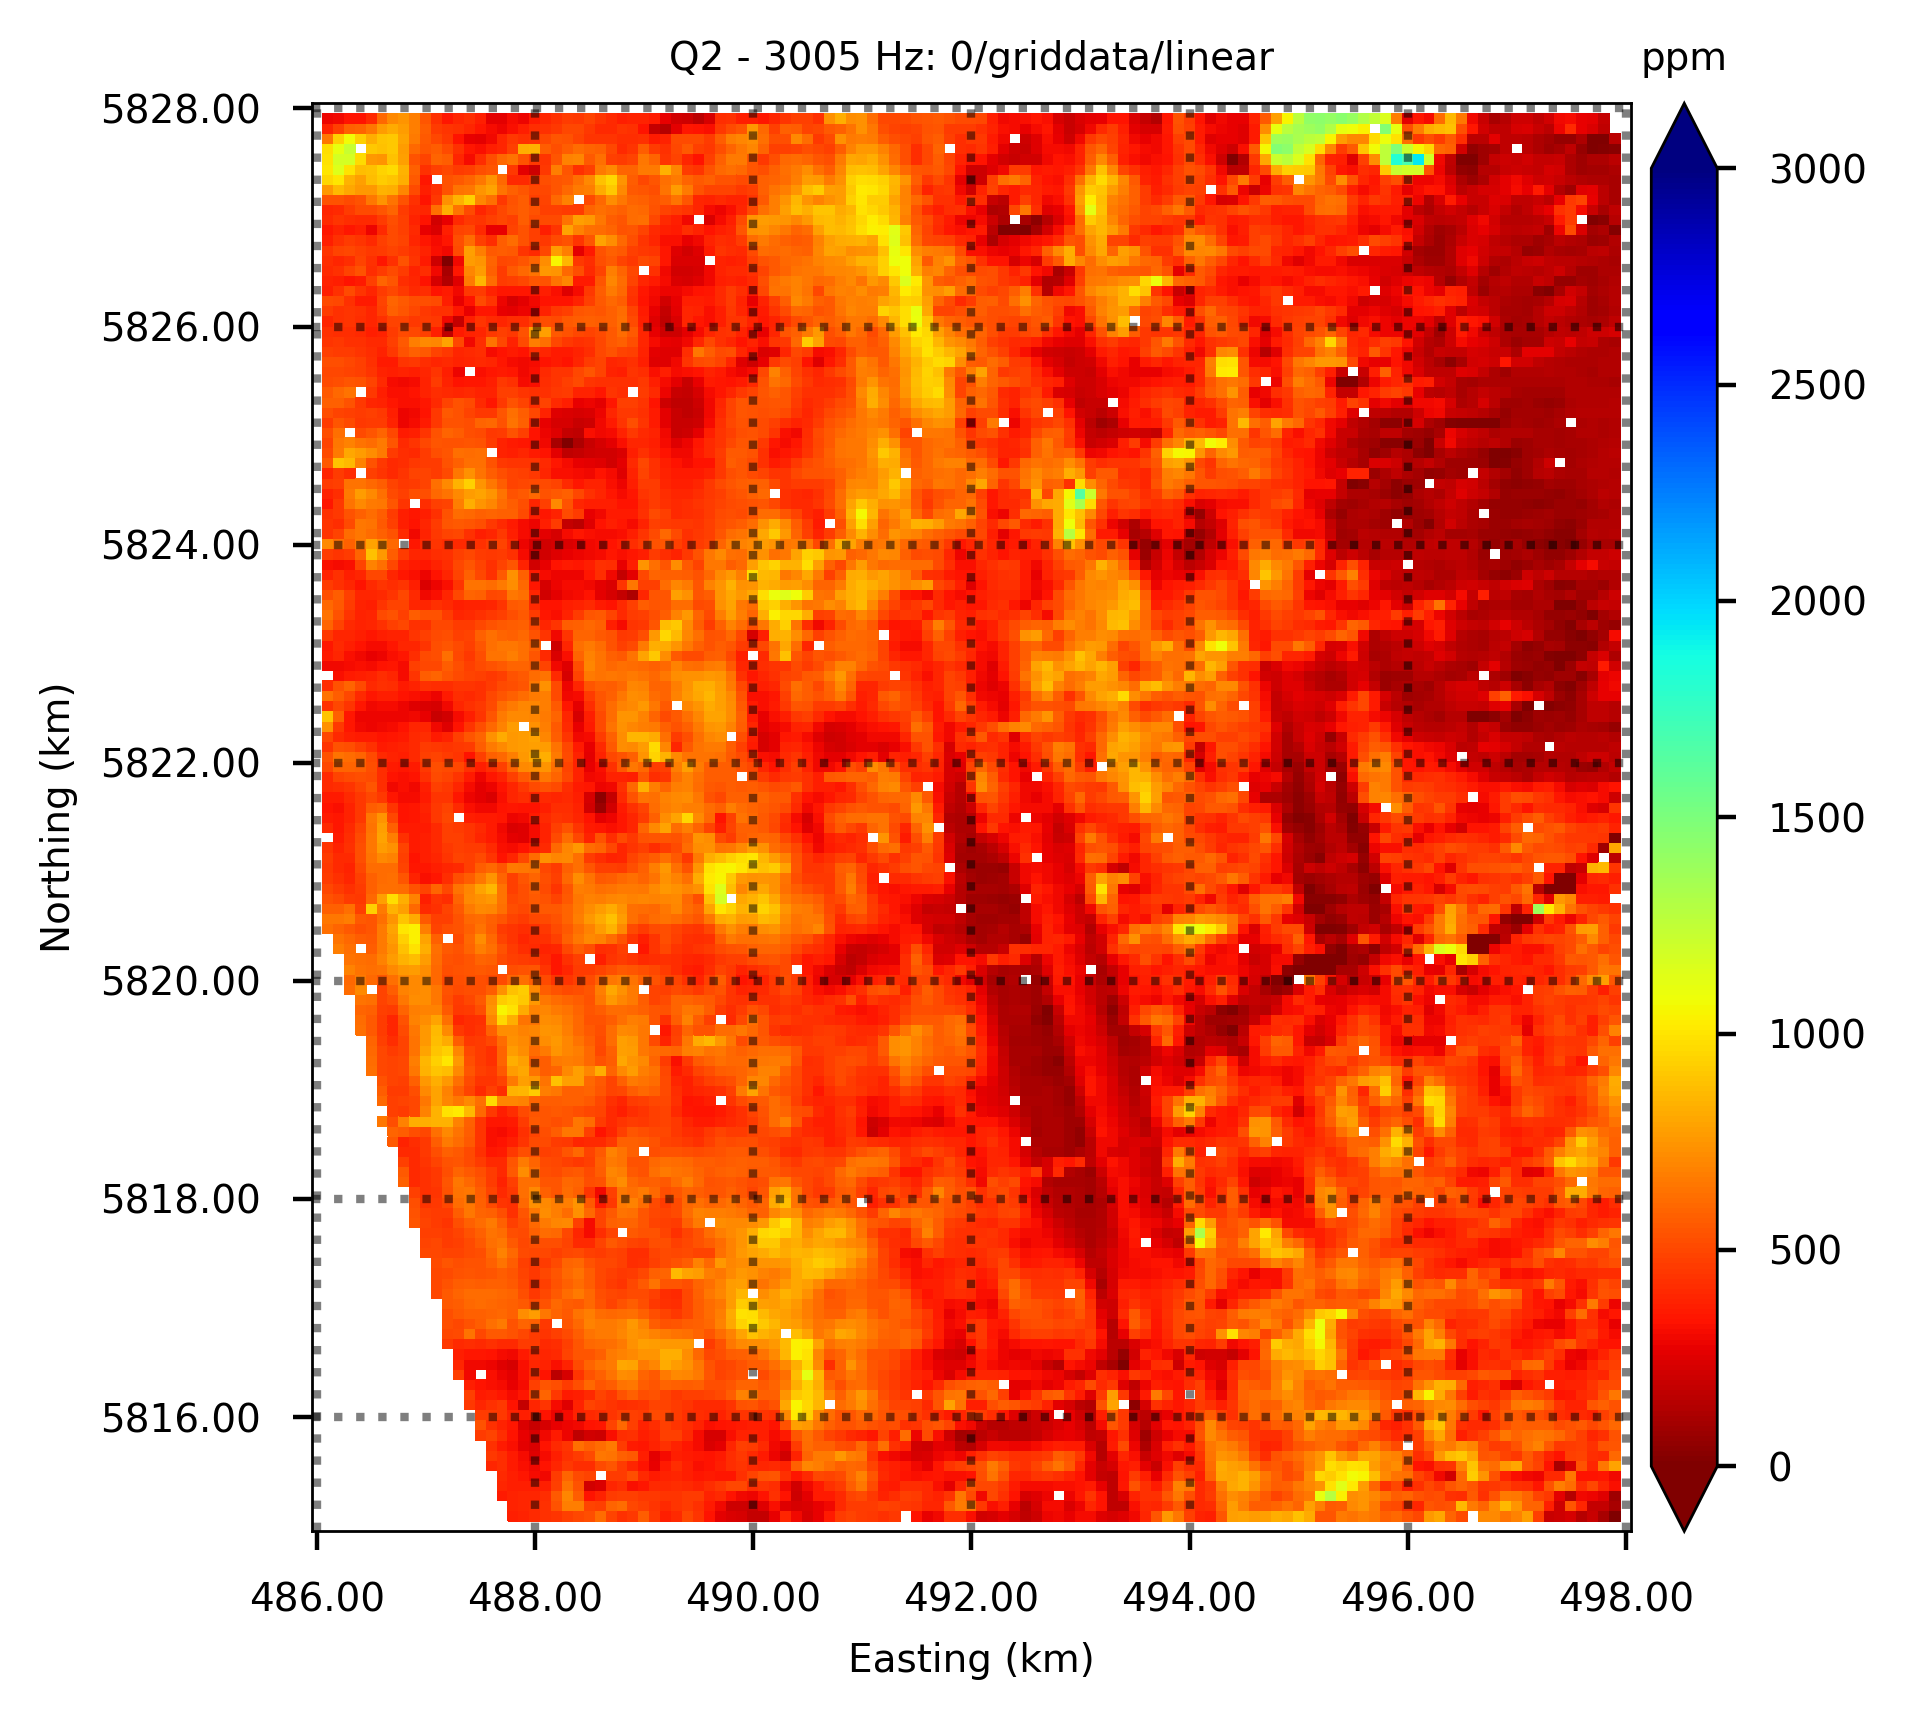

Plotting component P3 - 11962 Hz: 0/griddata/linear
Data, read   min=-212.0   max=4979.0
Data, interpolated   min=-112.11197786838115   max=4869.134170411442
Plot written to /home/vrath/AEMpyX_public//data//aem05_limerick/raw/plots/Limerick_shale_raw_aem05_image_P3_griddata_linear.pdf
Plot written to /home/vrath/AEMpyX_public//data//aem05_limerick/raw/plots/Limerick_shale_raw_aem05_image_P3_griddata_linear.png


<Figure size 2560x1760 with 0 Axes>

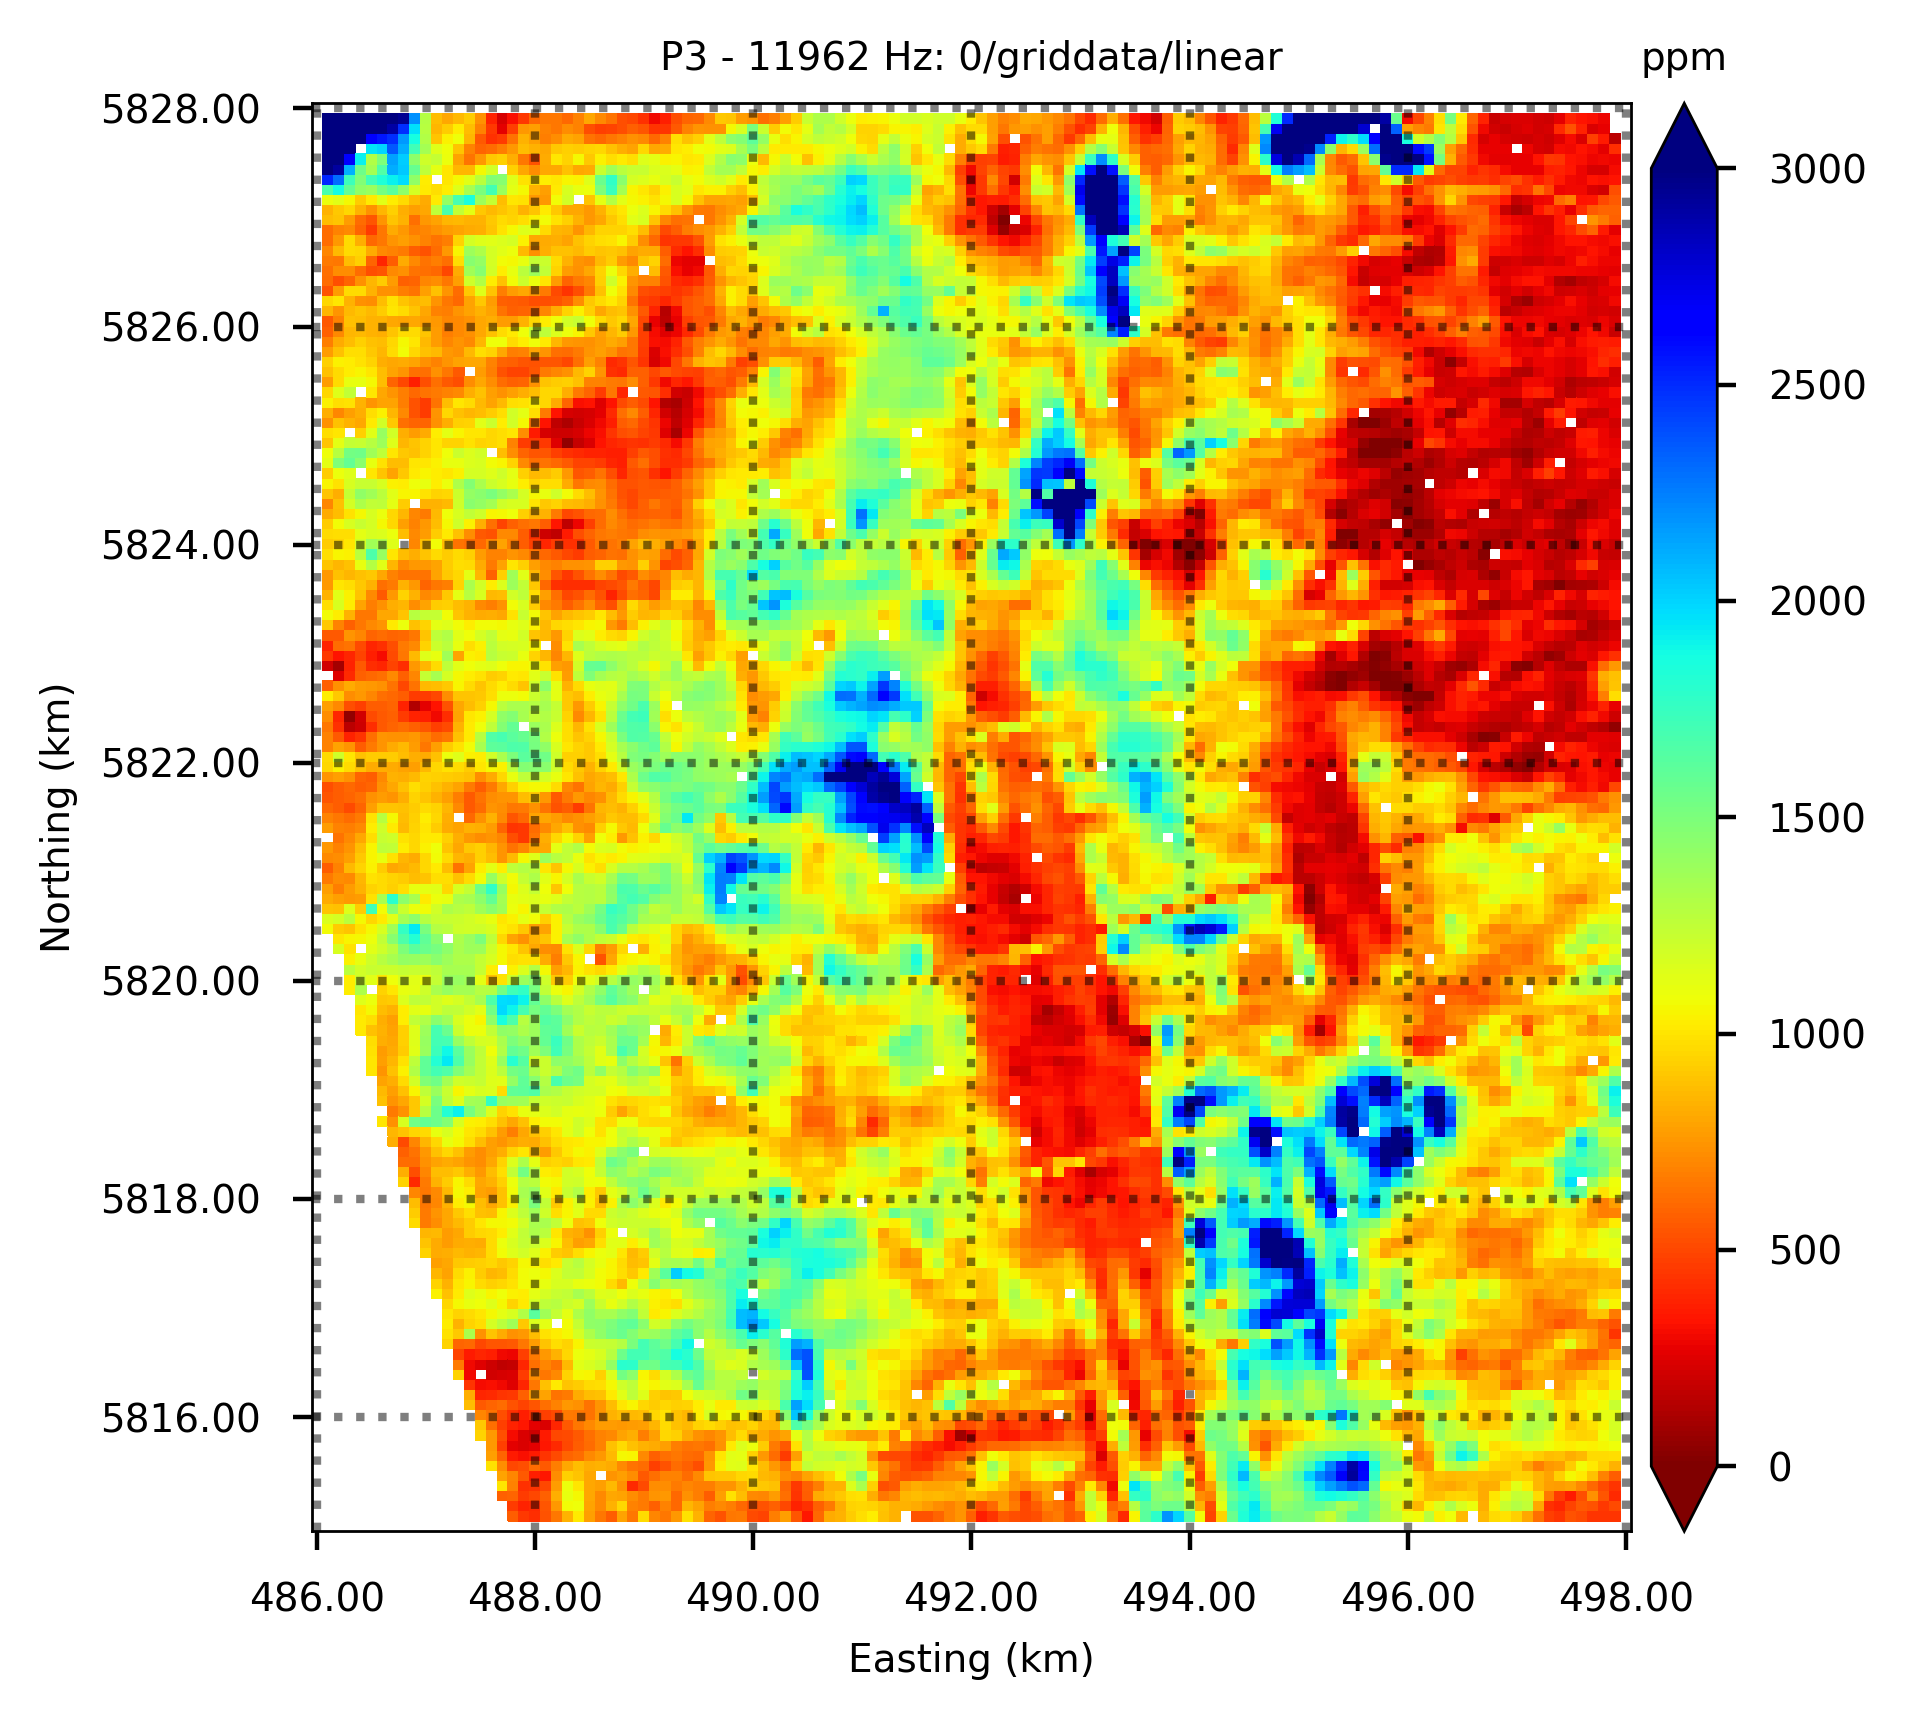

Plotting component Q3 - 11962 Hz: 0/griddata/linear
Data, read   min=61.0   max=2122.0
Data, interpolated   min=68.25114985909696   max=1992.9830410587185
Plot written to /home/vrath/AEMpyX_public//data//aem05_limerick/raw/plots/Limerick_shale_raw_aem05_image_Q3_griddata_linear.pdf
Plot written to /home/vrath/AEMpyX_public//data//aem05_limerick/raw/plots/Limerick_shale_raw_aem05_image_Q3_griddata_linear.png


<Figure size 2560x1760 with 0 Axes>

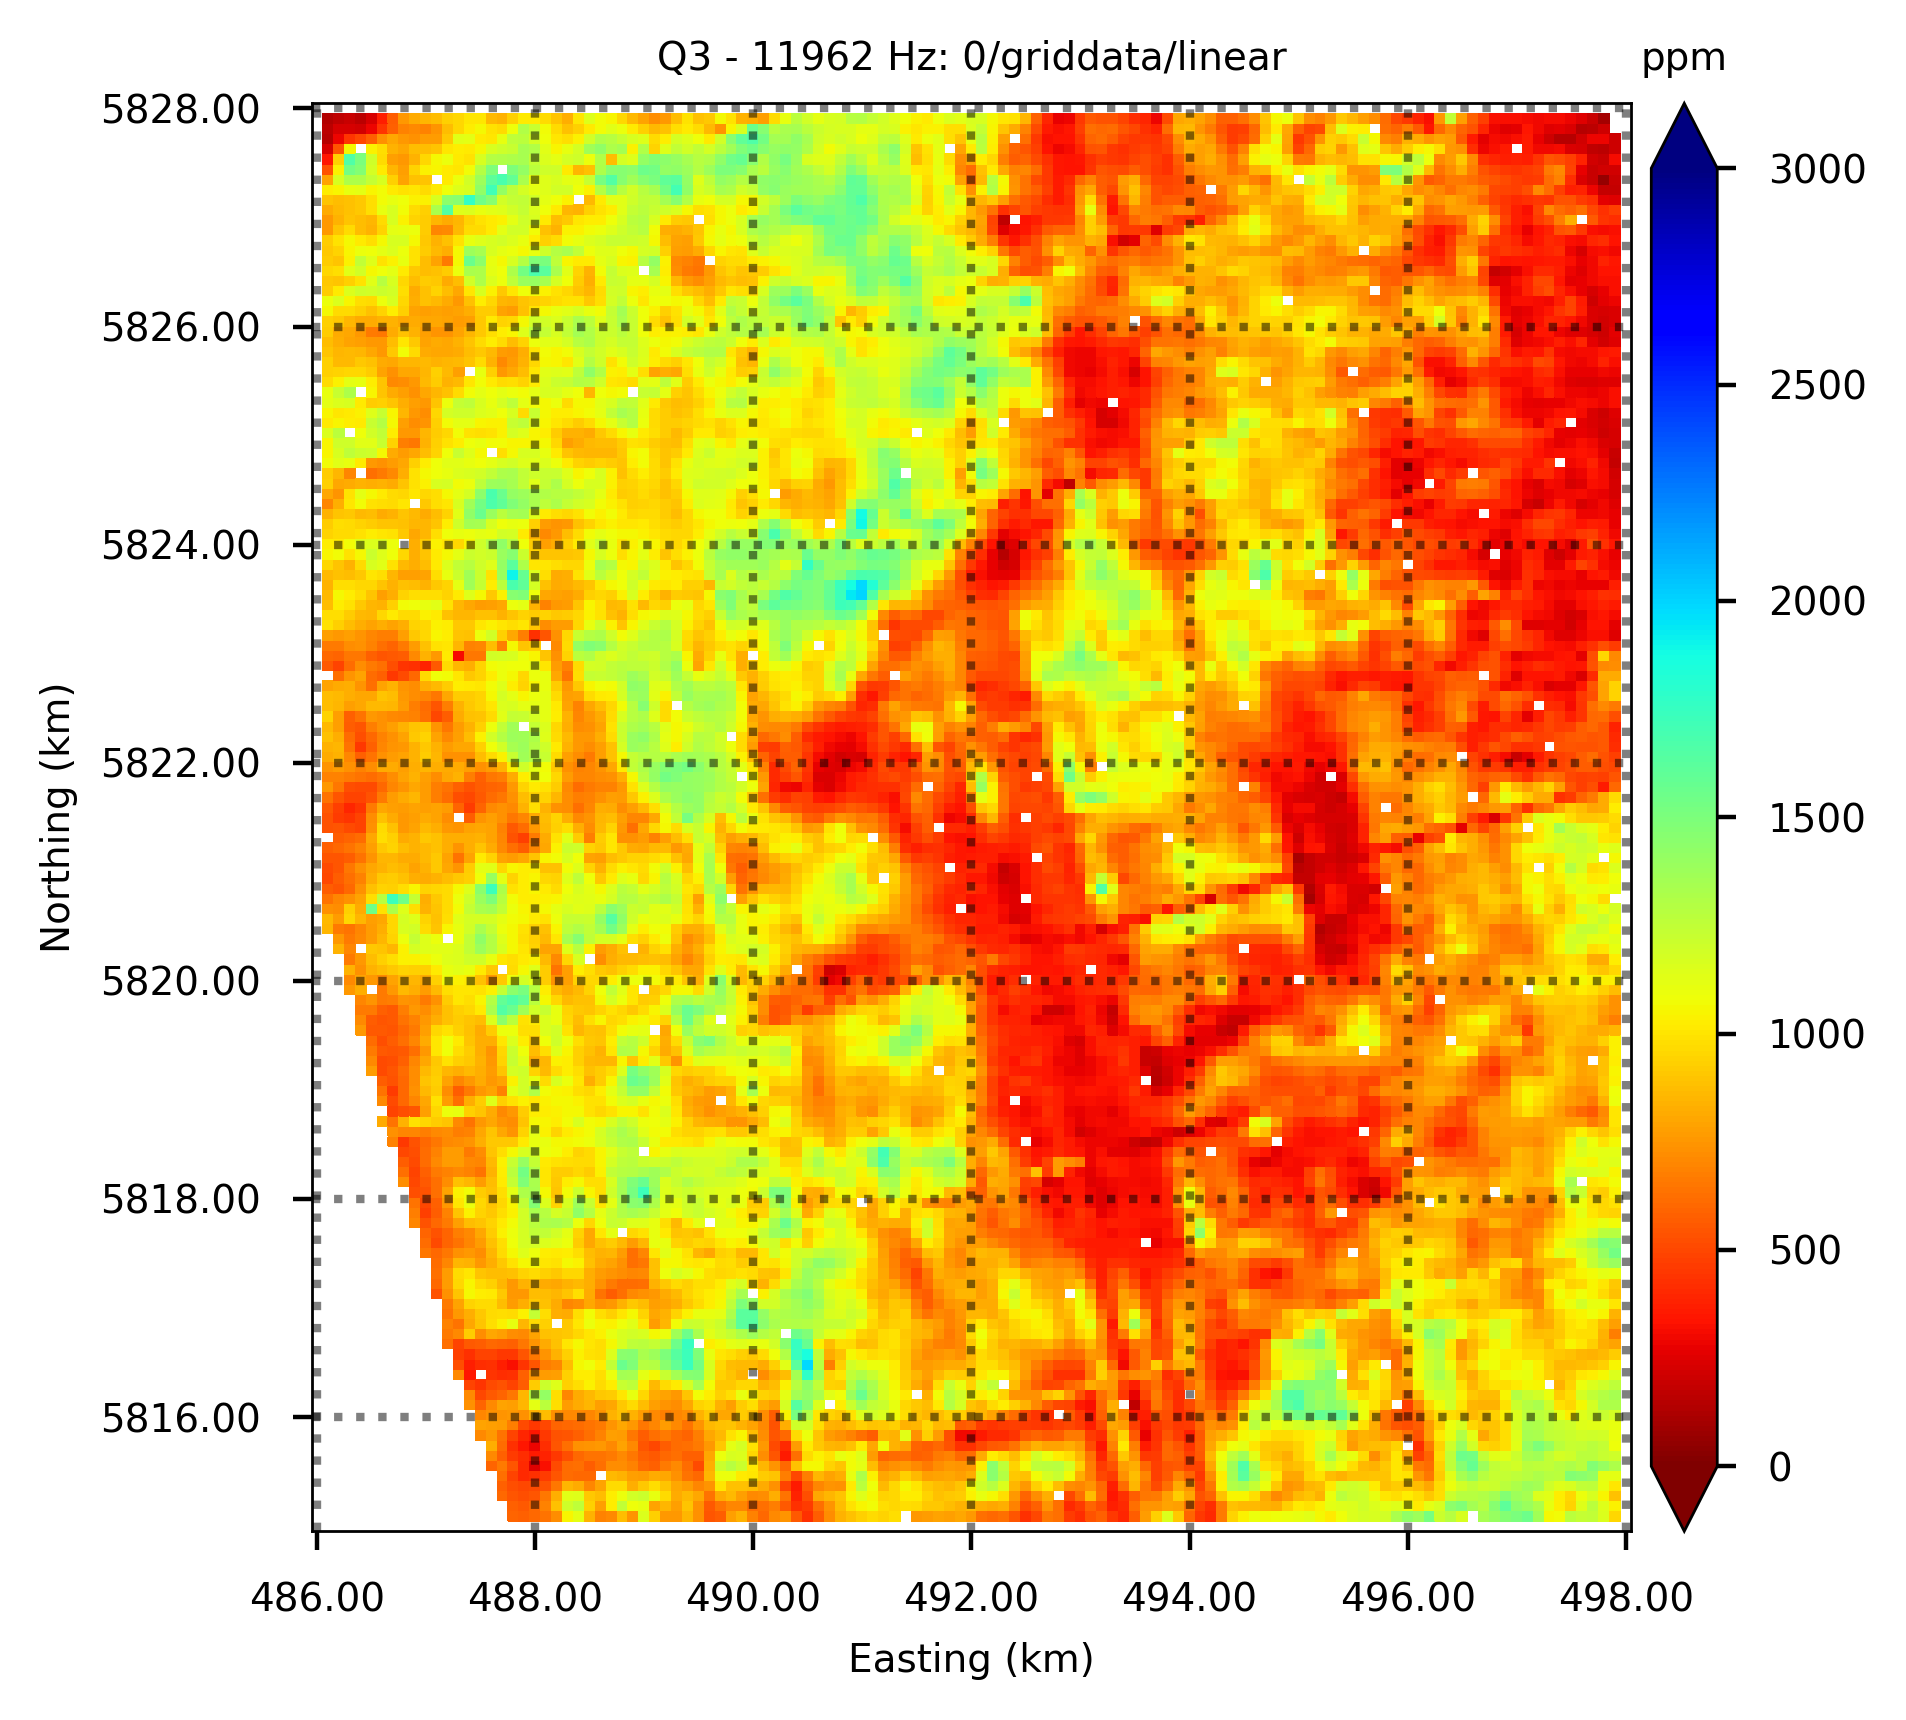

Plotting component P4 - 24510 Hz: 0/griddata/linear
Data, read   min=-415.0   max=5422.0
Data, interpolated   min=-295.7311083765365   max=5330.756434187546
Plot written to /home/vrath/AEMpyX_public//data//aem05_limerick/raw/plots/Limerick_shale_raw_aem05_image_P4_griddata_linear.pdf
Plot written to /home/vrath/AEMpyX_public//data//aem05_limerick/raw/plots/Limerick_shale_raw_aem05_image_P4_griddata_linear.png


<Figure size 2560x1760 with 0 Axes>

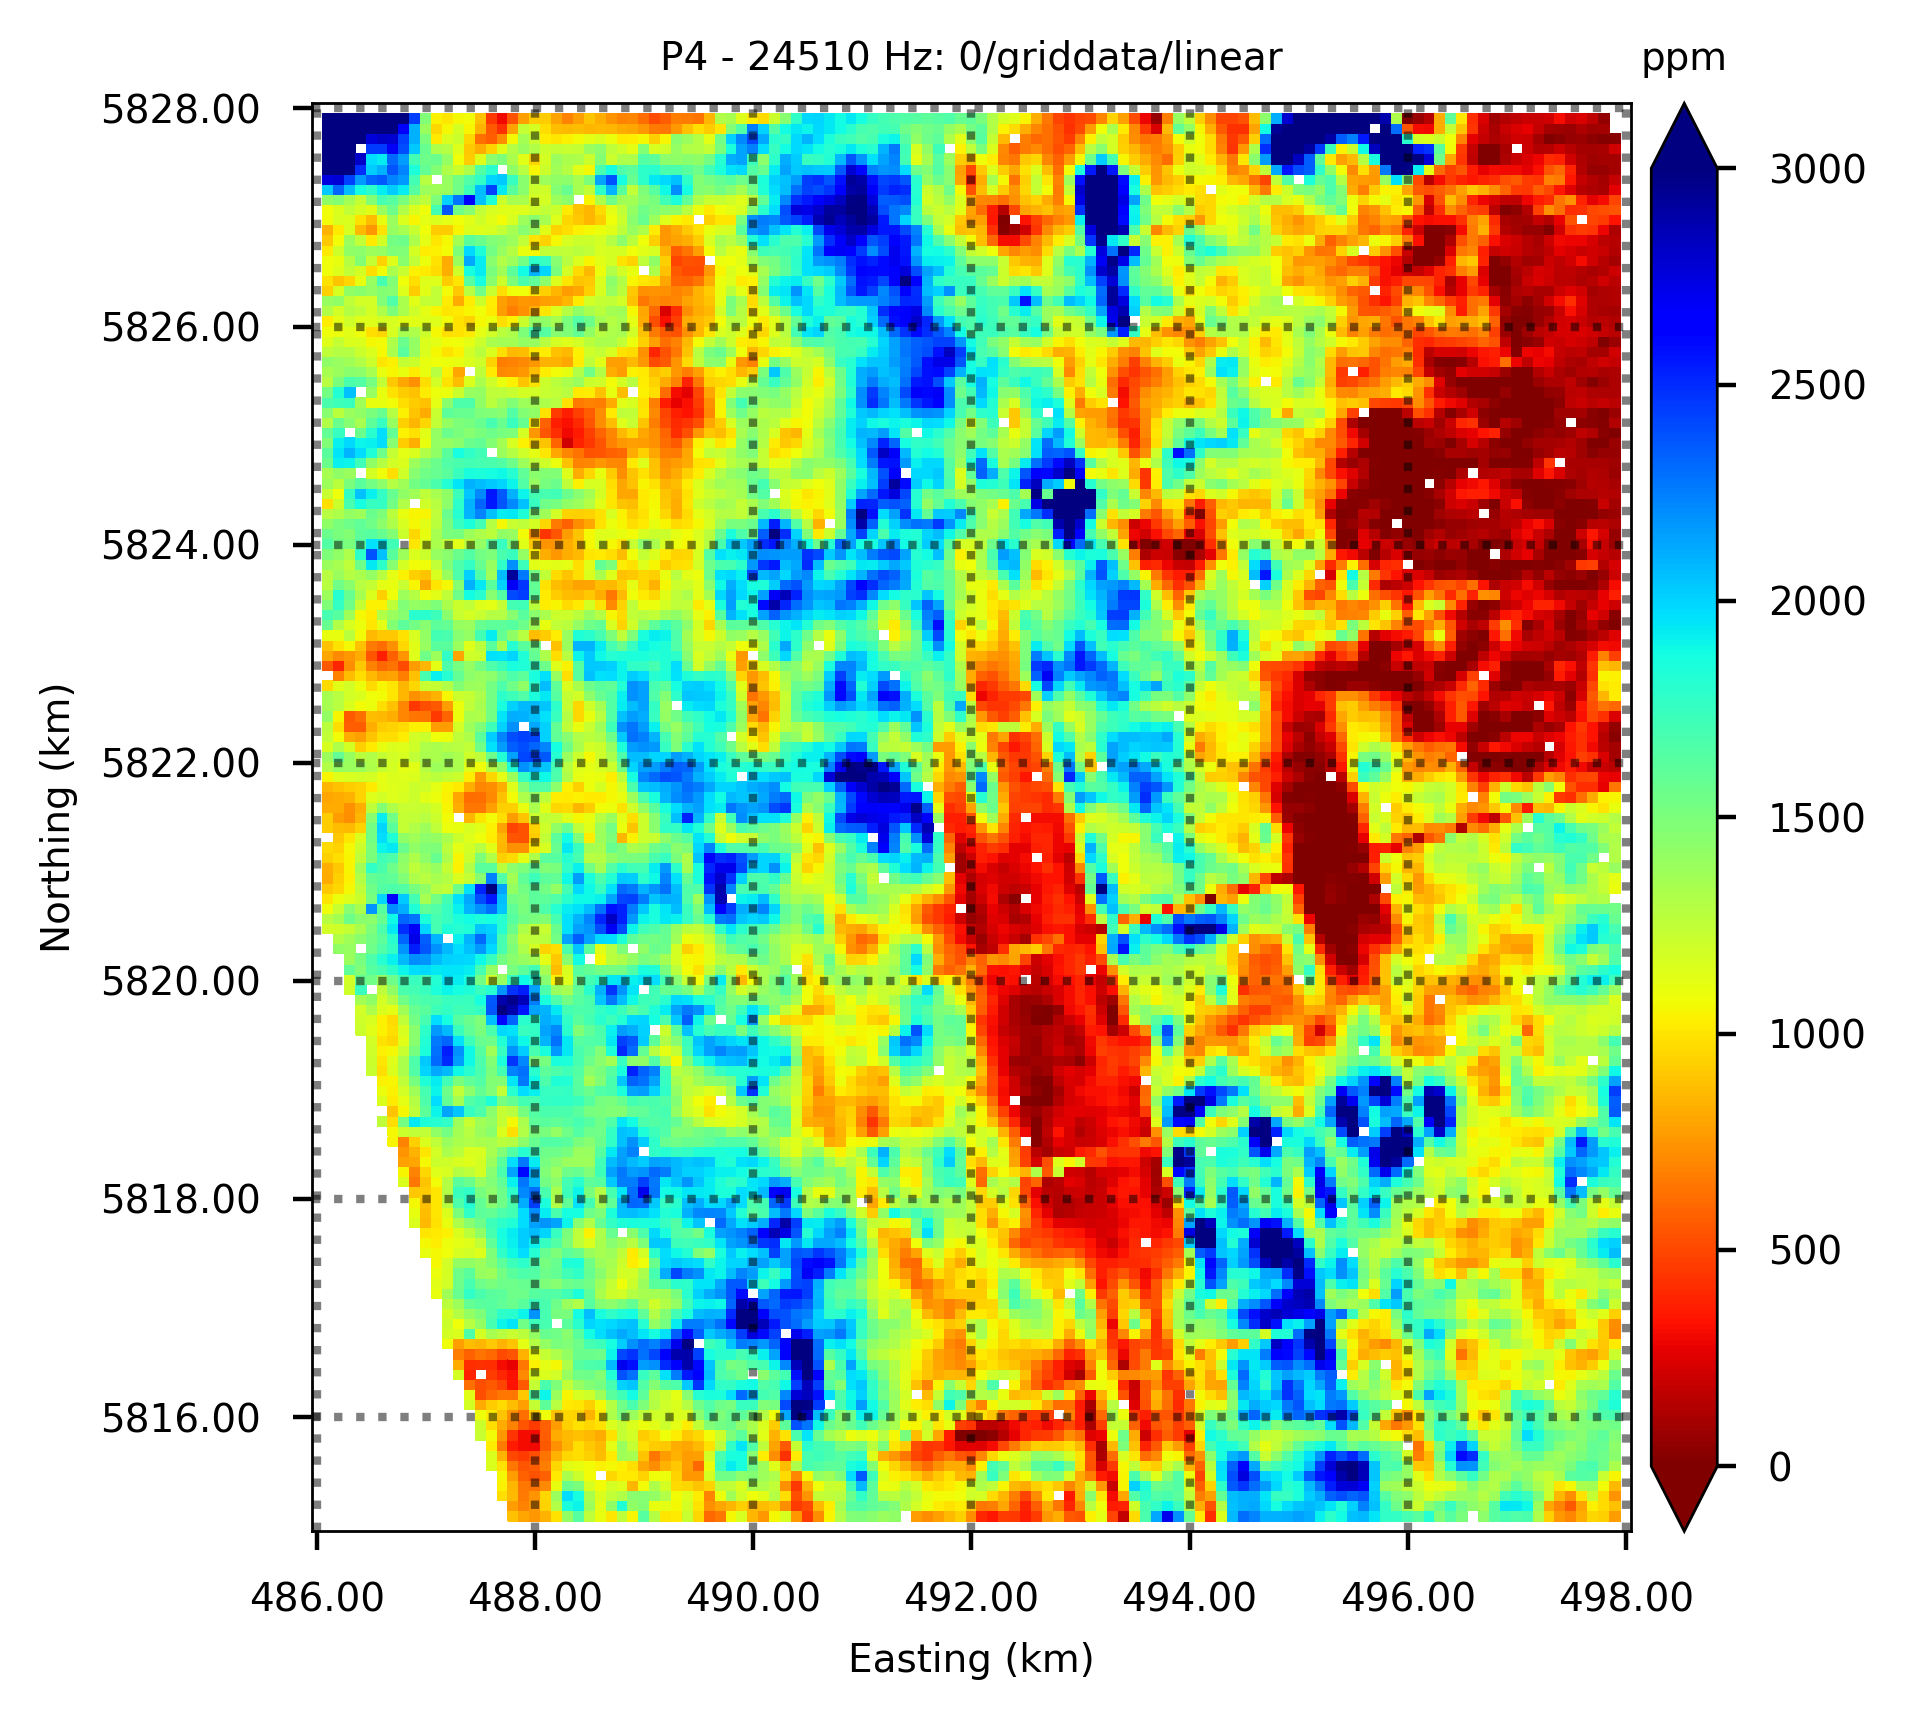

Plotting component Q4 - 24510 Hz: 0/griddata/linear
Data, read   min=-62.0   max=2722.0
Data, interpolated   min=-5.789898310785995   max=2651.982692757176
Plot written to /home/vrath/AEMpyX_public//data//aem05_limerick/raw/plots/Limerick_shale_raw_aem05_image_Q4_griddata_linear.pdf
Plot written to /home/vrath/AEMpyX_public//data//aem05_limerick/raw/plots/Limerick_shale_raw_aem05_image_Q4_griddata_linear.png


<Figure size 2560x1760 with 0 Axes>

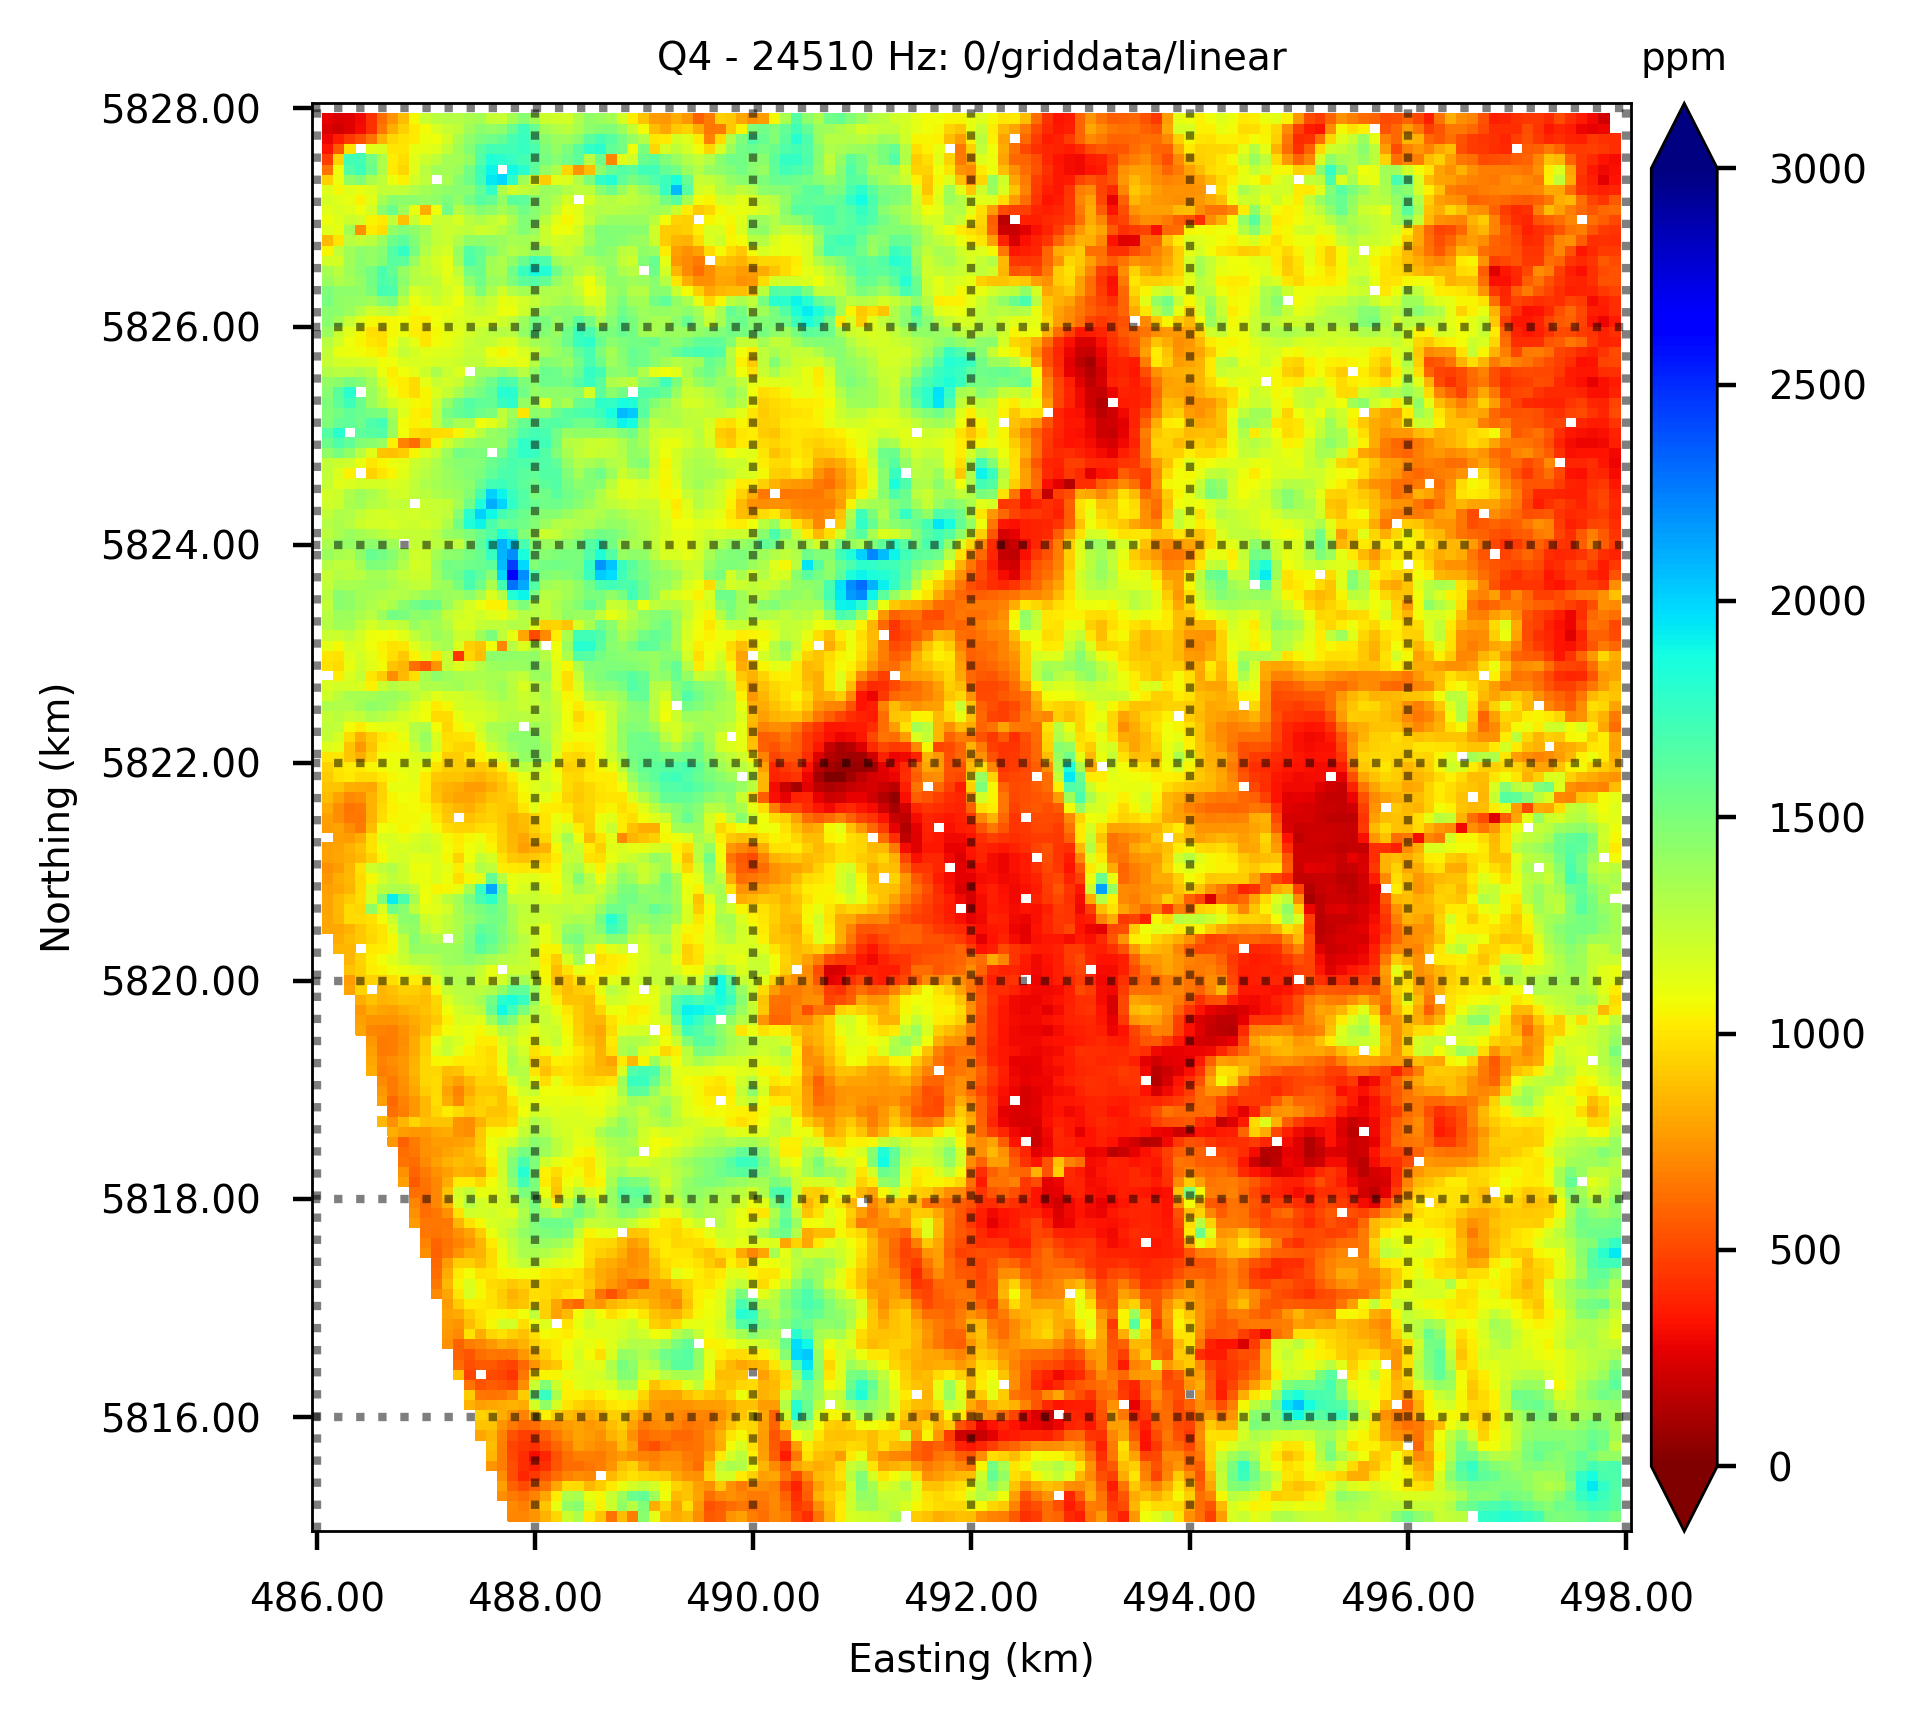

Plotting component PLM: 0/griddata/linear
Data, read   min=-0.04   max=151.53
Data, interpolated   min=3.0072188305132412   max=106.66279810609987
Plot written to /home/vrath/AEMpyX_public//data//aem05_limerick/raw/plots/Limerick_shale_raw_aem05_image_PLM_griddata_linear.pdf
Plot written to /home/vrath/AEMpyX_public//data//aem05_limerick/raw/plots/Limerick_shale_raw_aem05_image_PLM_griddata_linear.png


<Figure size 2560x1760 with 0 Axes>

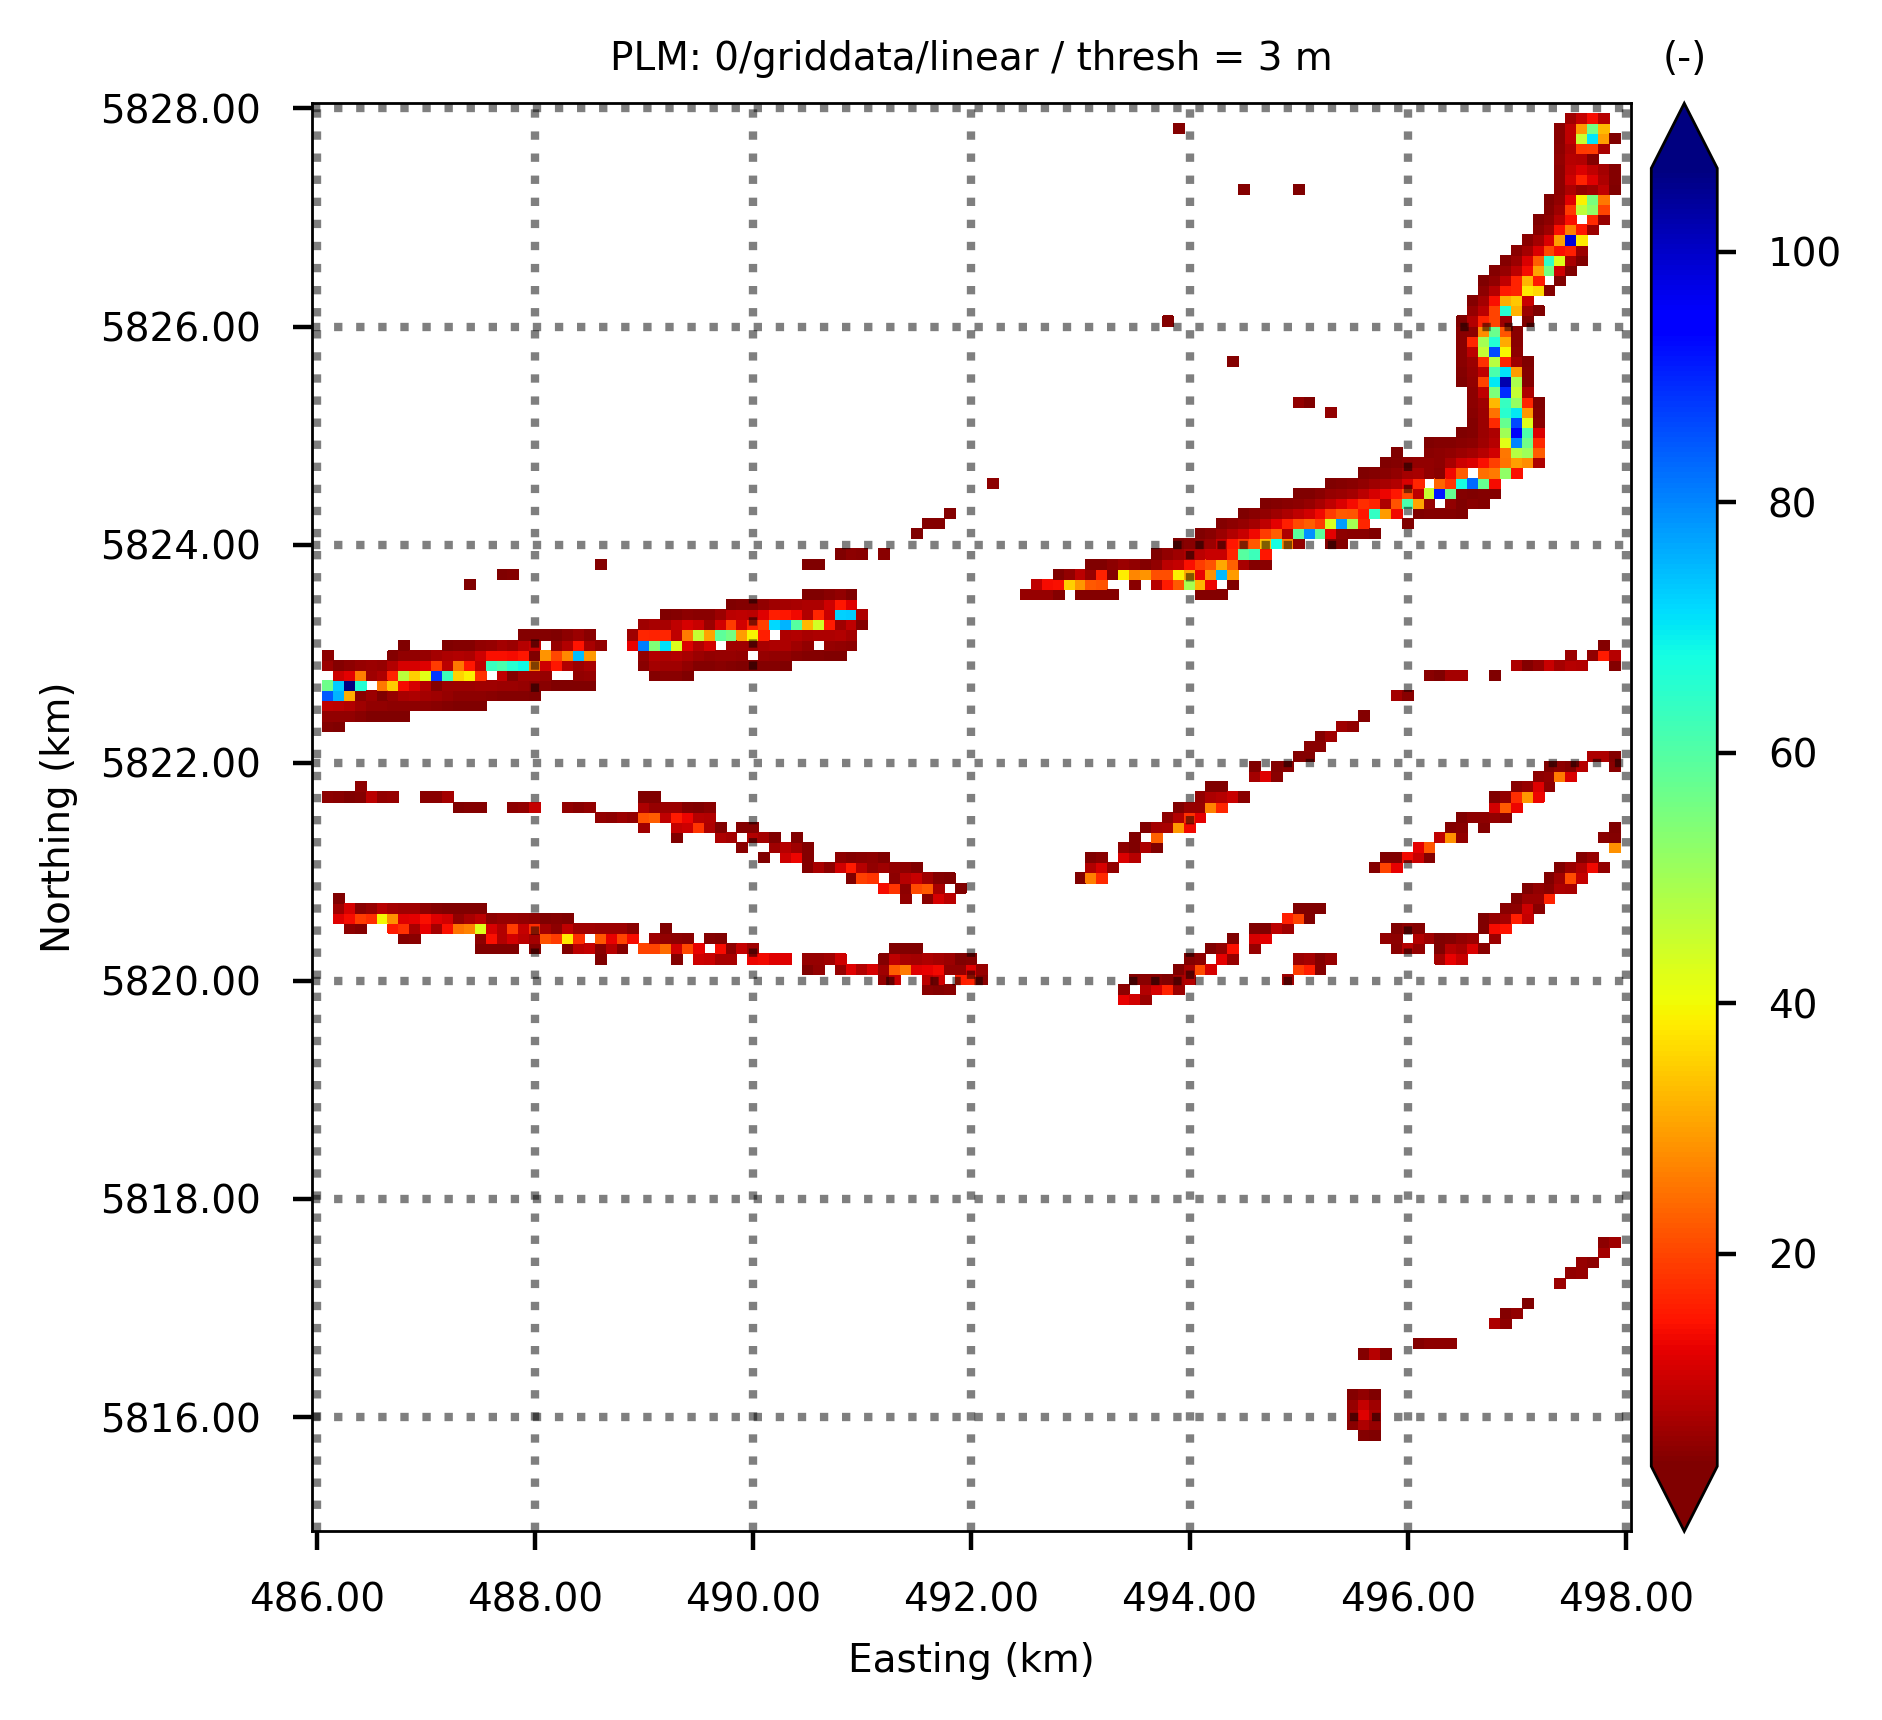

Plotting component ALT: 0/griddata/linear
Data, read   min=38.27   max=343.83
Data, interpolated   min=43.34704458309819   max=124.93452682050929
Plot written to /home/vrath/AEMpyX_public//data//aem05_limerick/raw/plots/Limerick_shale_raw_aem05_image_ALT_griddata_linear.pdf
Plot written to /home/vrath/AEMpyX_public//data//aem05_limerick/raw/plots/Limerick_shale_raw_aem05_image_ALT_griddata_linear.png


<Figure size 2560x1760 with 0 Axes>

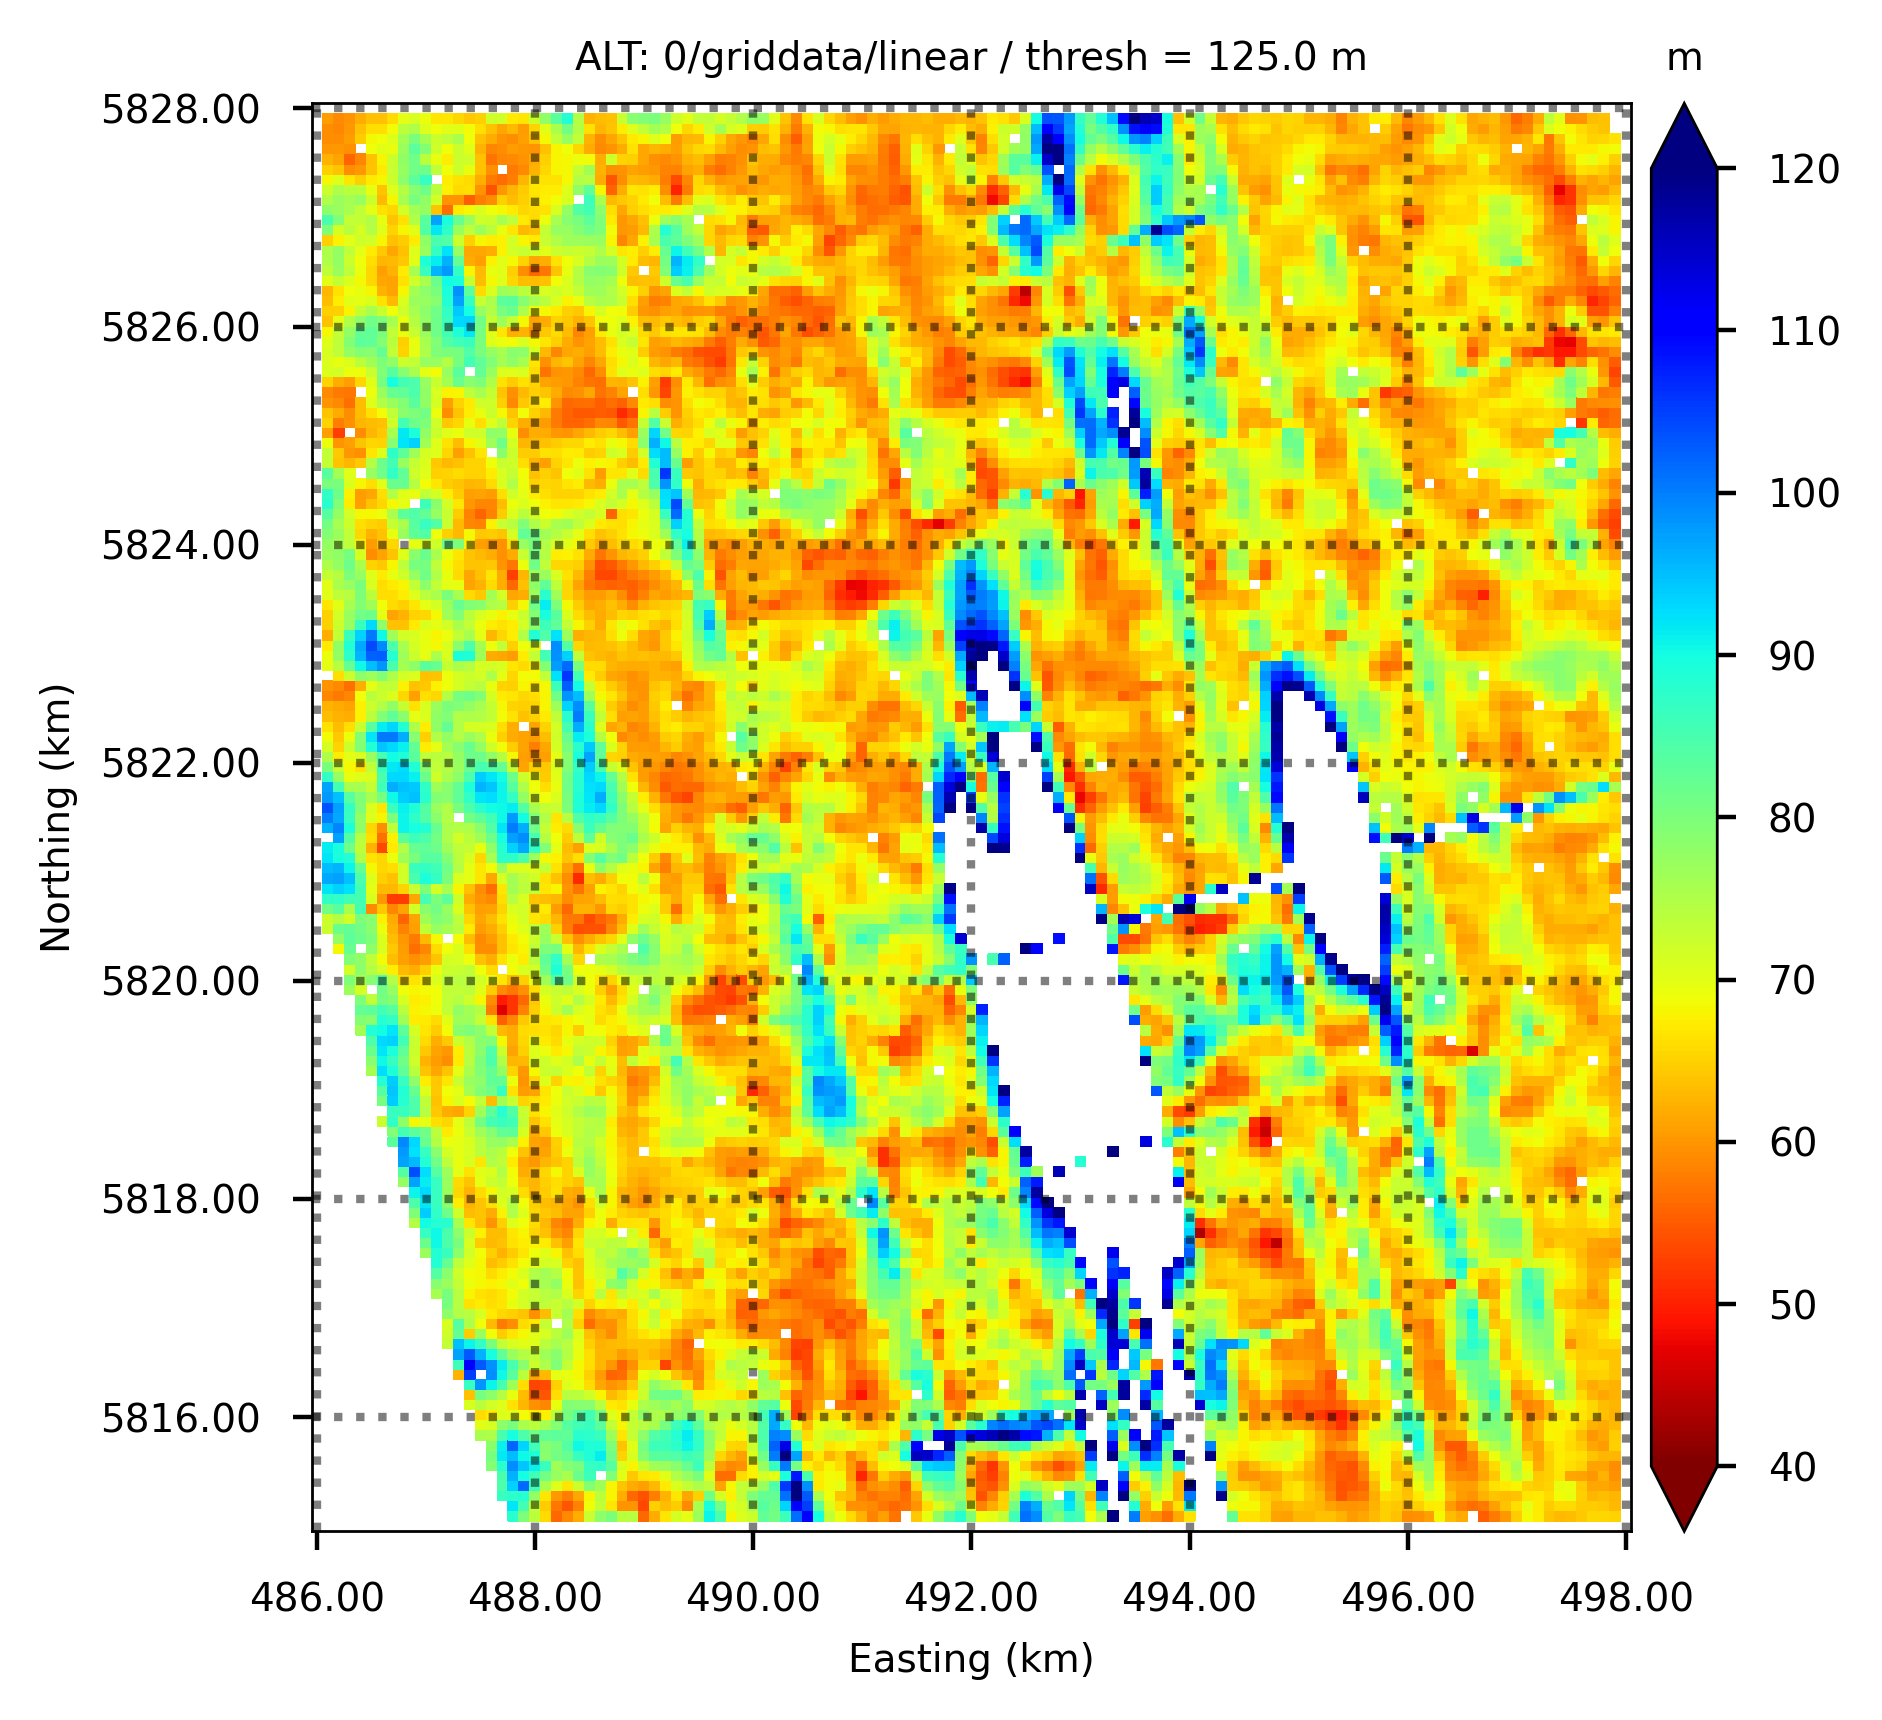

<Figure size 2560x1760 with 0 Axes>

In [53]:
for filein in dat_files:
    start = process_time()
    print("\nData read from: %s" % filein)
    Data, header, _ = aesys.read_aempy(File=filein, System=AEM_system, OutInfo=False)


    E = Data[:,1][::step]*XYFact
    E_min = numpy.amin(E)
    E_max = numpy.amax(E)
    N = Data[:,2][::step]*XYFact
    N_min = numpy.amin(N)
    N_max = numpy.amax(N)
    Z = Data[:,5][::step]

    if ("image" in ImageType.lower()) or ("contour"in ImageType.lower()):
        xi= numpy.linspace(E_min,E_max,numIndexes[0])
        yi= numpy.linspace(N_min,N_max,numIndexes[1])
        dx = numpy.around(numpy.diff(xi)[0]/XYFact, decimals=0)
        dy = numpy.around(numpy.diff(yi)[0]/XYFact, decimals=0)
        print("Interpolation mesh, dx = "+ str(dx)+" m, dy ="+ str(dy)+" m")
        XI, YI = numpy.meshgrid(xi, yi, indexing="ij")
        Pnts = numpy.stack([ E.ravel(),  N.ravel()], -1)
        Mesh = numpy.stack([XI.ravel(), YI.ravel()], -1)

        if MaskDist:
            D_tree=scipy.spatial.KDTree(Pnts, leafsize=10,
                                        compact_nodes=True,
                                        copy_data=True,
                                        balanced_tree=True,
                                        boxsize=None)
            mindist, _ = D_tree.query(Mesh, k=1)
            blankdist = mindist>=DistMask


        if MaskPoly:
            XIF = XI.flatten().reshape(-1,1)/XYFact
            YIF = YI.flatten().reshape(-1,1)/XYFact
            blankpoly=[]
            for ipnt in numpy.arange(numpy.size(XIF)):
                outside = not util.point_inside_polygon(XIF[ipnt], YIF[ipnt],
                                                        Polygon)
                blankpoly.append(outside)


    pdf_list = []
    # for Comp in CompList:
    for nc in numpy.arange(len(CompList)):

        Comp = CompList[nc][0]

        comp = CompDict[Comp][0]
        indx = CompLabl.index(Comp)

        if "scatter"in ImageType.lower():
            titl = CompLabl[indx]+CompDict[Comp][2]+": "+str(DataTrans)
        else:
            titl = CompLabl[indx]+CompDict[Comp][2]+": "+str(DataTrans)+"/"+InterpMethod[0]+"/"+InterpMethod[1]

        print("Plotting component "+titl)
        D = Data[:,comp][::step]

        D_min = numpy.amin(D)
        D_max = numpy.amax(D)
        print("Data, read   min="+str( D_min)+"   max="+str( D_max))

        if ("Z" in Comp) or ("H" in Comp):
            Unit = "ppm"
            if DataTrans ==1:
                Unit = "-"
                D = numpy.log10(D)
            if DataTrans ==2:
                Unit = "-"
                if not numpy.isfinite(S):
                   S = inverse.get_S(D)
                D= numpy.arcsinh(D/S)
                print("Scaling Value S for arcsinh:"+str(S))

        if ("P" in Comp) or ("Q" in Comp):
            Unit = "ppm"
            if DataTrans ==1:
                Unit = "-"
                D = numpy.log10(D)
            if DataTrans ==2:
                Unit = "-"
                if not numpy.isfinite(S):
                    S = inverse.get_S(D)
                D= numpy.arcsinh(D/S)
                print("Scaling Value S for arcsinh:"+str(S))

        if ("PL" in Comp):
            Unit = "(-)"
            PLMthresh= CompList[nc][2]
            titl = titl+" / thresh = "+str(PLMthresh)+" m"

        if ("A" in Comp):
            Unit = "m"
            ALTthresh= CompList[nc][2]
            titl = titl+" / thresh = "+str(ALTthresh)+" m"

        if ("R" in Comp):
            Unit = "Ohm.m"


        fig, ax = matplotlib.pyplot.subplots()
        fig.set_figwidth(FigWidth)


        if ("scatter" in ImageType.lower()):
            print("Scatter Plot")

            if Pixelsize:
                Markersize =(72./fig.dpi)

            if ("PL" in Comp):
                D[D<=PLMthresh]=numpy.nan
            if ("A" in Comp):
                D[D>=ALTthresh]=numpy.nan

            if MaskNeg:
                D[D<=0.]= numpy.nan

            if Pixelsize:
                im = matplotlib.pyplot.scatter(E, N, color='black', marker='.', lw=0, s=(sfac*72./fig.dpi)**2)
            else:
                im = matplotlib.pyplot.scatter(E, N, c=D, s=Markersize**2, cmap=cmp)

            # ax = matplotlib.pyplot.gca()
            ax.set_aspect("equal")
            ax.xaxis.set_major_formatter(xformatter)
            ax.set_xlabel("Easting "+XYUnits, size=Fontsizes[1])
            ax.yaxis.set_major_formatter(yformatter)
            ax.set_ylabel("Northing "+XYUnits, size=Fontsizes[1])

            ax.tick_params(axis="x", labelsize=Fontsizes[1]-2, labelrotation=0.)#-45)
            ax.tick_params(axis="y", labelsize=Fontsizes[1]-2, labelrotation=0.)#-45)
            ax.grid(which="major", axis="both", visible=True,linewidth= Linewidths[0],linestyle="--")
            ax.set_title(AEM_system.upper()+": "+ Comp)

            divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.02)
            cb = matplotlib.pyplot.colorbar(im, cax=cax, extend="both")
            cb.ax.tick_params(labelsize=Fontsizes[1])
            cb.ax.set_title(Unit, fontsize=Fontsizes[1])


        if ("image" in ImageType.lower()) or ("contour"in ImageType.lower()):
            Dats = D.flatten()
            if "grid" in InterpMethod[0].lower():
                DI = scipy.interpolate.griddata(Pnts, Dats, Mesh,
                                                method=InterpMethod[1].lower())
                DI = numpy.reshape(DI,(len(xi), len(yi)))

            elif "rbf" in InterpMethod[0].lower():
                # RBF = scipy.interpolate.Rbf(E, N, D,
                #                             function=InterpMethod[1].lower(), smooth=InterpMethod[2])
                # DI  = RBF(XI, YI)
                Pnts = numpy.stack([ E.ravel(),  N.ravel()], -1)
                Mesh = numpy.stack([XI.ravel(), YI.ravel()], -1)
                Dats = D.ravel()
                RBF = scipy.interpolate.RBFInterpolator(
                            Pnts, Dats,
                            kernel=InterpMethod[1], smoothing=InterpMethod[2])
                DI = RBF(Mesh)
                DI = numpy.reshape(DI,(len(xi), len(yi)))


            elif "krig" in InterpMethod[0].lower():
                error("Kriging estimation not yet implemented! Exit.")


            if ("PL" in Comp):
                DI[DI<=PLMthresh]=numpy.nan
            if ("A" in Comp):
                DI[DI>=ALTthresh]=numpy.nan

            if MaskNeg:
                DI[DI<=0.]= numpy.nan

            if MaskPoly:
                DIF = DI.flatten().reshape(-1,1)
                DIF[blankpoly] = numpy.nan
                DI = numpy.reshape(DIF,(len(xi), len(yi)))

            if MaskDist:
                DIF = DI.flatten().reshape(-1,1)
                DIF[blankdist] = numpy.nan
                DI = numpy.reshape(DIF,(len(xi), len(yi)))


            D_min = numpy.nanmin(DI)
            D_max = numpy.nanmax(DI)
            print("Data, interpolated   min="+str( D_min)+"   max="+str( D_max))


            if len(CompList[nc][1])==0:
                if ("image" in ImageType.lower()):
                    im = ax.pcolor(XI, YI, DI, cmap=cmp)
                if ("contour" in ImageType.lower()):
                    im = ax.contourf(XI, YI, DI, cmap=cmp, levels=Levels)
            else:
                if ("image" in ImageType.lower()):
                    valmin, valmax, _ = CompList[nc][1]
                    im = ax.pcolor(XI, YI, DI,
                                   cmap=cmp,
                                   vmin=valmin, vmax=valmax)
                if ("contour" in ImageType.lower()):
                    valmin, valmax, valdel = CompList[nc][1]
                    levels = numpy.arange(valmin, valmax+valdel, valdel)
                    im = ax.contourf(XI, YI, DI,
                                     cmap=cmp,
                                     vmin=valmin, vmax=valmax,
                                     levels=levels)

            ax.set_aspect("equal")
            ax.xaxis.set_major_formatter(xformatter)
            ax.set_xlabel("Easting "+XYUnits, size=Fontsizes[1])
            ax.yaxis.set_major_formatter(yformatter)
            ax.set_ylabel("Northing "+XYUnits, size=Fontsizes[1])

            ax.set_title(titl,fontsize=Fontsize)

            ax.grid(color="k", alpha=0.5, linestyle="dotted", linewidth=1.5)
            ax.tick_params(labelsize=Labelsize)


            divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)

            cb = matplotlib.pyplot.colorbar(im, cax=cax, extend="both")
            cb.ax.tick_params(labelsize=Fontsizes[1])
            cb.ax.set_title(Unit, fontsize=Fontsizes[1])

        if "scatter" in ImageType.lower():
            plotfile = PlotDir+PlotName+"_"+AEM_system\
                +"_"+ImageType\
                +"_"+ Comp
        else:
            plotfile = PlotDir+PlotName+"_"+AEM_system\
                +"_"+ImageType\
                +"_"+ Comp\
            +"_"+InterpMethod[0].lower()\
            +"_"+InterpMethod[1].lower()


        for F in PlotFmt:

            print("Plot written to "+plotfile+F)
            matplotlib.pyplot.savefig(plotfile+F,
                                      dpi=600,
                                      bbox_inches="tight",
                                      backend= "cairo",
                                      transparent=True)


        if PDFCatalog:
            pdf_list.append(plotfile+".pdf")

        matplotlib.pyplot.show()
        matplotlib.pyplot.clf()

In [54]:
if PDFCatalog:
    viz.make_pdf_catalog(PDFList=pdf_list, FileName=PDFCName)


10 files collected to Limerick_shale_raw_catalog.pdf
